<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C2S3_Competition/sequences/P1C2_OptimizationAndEnvironment/P1C2_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a sixth test sequence for an upcoming text book on computational neuroscience from an optimization/learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as a learning algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

# **Part 1 Behaviour, Environments and Optimization: Evolution and Learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* **environment**, the (statistical) properties of where an organism lives
* **behaviour**, the statistics of what the organism does
* **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment

This is a core reason for writing this book: we can view pretty much anything happening in the brain (and biology) as being part of a process that brings about improvement in this sense.

___
# Chapter 1.3 Real Evolution

### Objective: In the previous chapters we learned to describe and think about behaviour as a policy, to evaluate an organism's behaviour relative to the goals implied by its environmental niche, and to use a variety of optimization algorithms to improve an organisms behaviour relative to its niche, i.e. to adapt the behaviour to the environment. In this next chapter we are going to look at how evoltutionary processes, i.e. natural selection for survivability and reproduction, provide a powerful framework understanding much of the observable universe, neuroscience included!

You will learn:
*   What an evolutionary process is and how it provides some structure for answering fundamental why questions, e.g. why do we observe the world in this one state and not some other state.
*   Why sex is so important.
*   How competition and interaction complicate optimization. Optimization in a strict sense does not directly apply to situations with multiple interacting organisms, each with their own goals that they are simultaneously optimizing for. Ideas from Game Theory and dynamical systems are required to do multi-organism 'optimization' the right way.
*   How learning and evolution interact as parts of a nested optimization loop (Learning -> Inner, Evolution -> Outer), that is more efficient at producung adaptive behaviour than either process in isolation.     

___
# **1.3.3: Competition Transforms Optimization into Game Theory**

### Objective: In the last chapter we saw how alignement with environmental context is key to the effectiveness of a policy and how a changing environment thus creates a challenge to producing effective behaviour. In this seqeunce we will expand on this theme by considering a major source of 'environmental' variation, adaptive behaviour of other organsims. One organism's policy is another organism's environment! In this sequence you will:
* Extend our 'propose and test' algorithm and our basic 'Parameterized Weights' policy function to allow different organsims to adapt to eachother's behaviour in a shared environment.
* Investigate this mutual behaviour adaption process in a situations where organisms play by fundamentally different rules, in this case a prey organism trying to eat plants and aviod being eaten, while a preditor organism trys to eat the prey organism.
* Learn a tiny bit about Nash Equilibria and how they relate to optimization and dynamical systems.

Picture of rock paper scissors
![Placeholder Image](https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/P1C2S3_Competition/s/Art/RPS.jpg)

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

!pip install ipympl vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
import time
import logging
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from enum import Enum
from copy import copy
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm


# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C2_S2"




################################################################
# refactor Monte Carlo for boards that support multiple critters
################################################################




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """


  def __init__(self, game, nnet, default_depth=5, random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.rng = np.random.default_rng(seed=random_seed)


  def pis_vs_from_board(self, board, critter):
    #helper function, to put board in canonical form that nn was trained on
    batch_size, n_rows, n_cols = board['pieces'].shape
    co_pieces = board['pieces'].copy()
    this_critter_locs = np.where(co_pieces == critter)
    all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    co_pieces[this_critter_locs] = 1
    scalar_rounds_left = board['rounds_left'][0]
    co_rounds_left = scalar_rounds_left // self.game.num_critters
    if critter-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
       co_rounds_left = co_rounds_left + 1
    co_rounds_left = np.array([co_rounds_left]*batch_size)
    pis, vs = self.nnet.predict(co_pieces,
                                board['scores'][:,critter-1],
                                co_rounds_left)
    return pis, vs


  def simulate(self, board, actions, action_indexes, critter=1, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer indexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board['pieces'].shape
    next_board = self.game.get_next_state(board, critter,
                                          actions, action_indexes)
    # in this version of the mc player, the existence of other players is
    # ignored, in another version of mc other players moves might be simulated
    next_board['active_player'] = critter-1

    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straight rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board['pieces'].shape

    for i in range(depth):  # maxDepth
      if next_board['rounds_left'][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board['scores'][:,critter-1].copy()
        return terminal_vs
      else:
        #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'], next_board['rounds_left'])
        pis, vs = self.pis_vs_from_board(next_board, critter)
        valids = self.game.get_valid_actions(next_board, critter)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = self.rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, critter,
                                            sampled_actions)
      # in this version of the mc player, existence of other players is ignored
      # in another better version other players moves might be simulated, either
      # as copies of self, or as distinct environmental dynamics
      next_board['active_player'] = critter-1


    pis, vs = self.pis_vs_from_board(next_board, critter)
    #pis, vs = self.nnet.predict(next_board['pieces'], next_board['scores'],
    #                            next_board['rounds_left'])
    #print(vs.shape)
    return vs




# @title plotting functions
#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]]) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=250, marker=spec['marker'],
                           color=spec['color'], label=spec['name'])
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov,
             opaque=False, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    if opaque:
      mask_array[:, :, 3] = 1.0  # 50% opacity
    else:
      mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()





















Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


In [83]:
# @title GridworldBoard class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  board state is represented by primarily by pieces, score, and rounds left
  pieces is a batch x n_rows x n_cols numpy array positive integers are critter
  locations 0's are empty space and -1's are food.

  For pieces first dim is batch, second dim row , third is col,
  so pieces[0][1][7] is the square in row 2, in column 8 of the first board in
  the batch of boards.

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  active_player keeps track of which players turn it is

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  class CritterFoodType(Enum):
    FOOD = "food"
    PREY = "prey"
    PREDATOR = "predator"

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, num_prey=1, num_pred=1,
               lifetime=30, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.num_prey = num_prey
    self.num_pred = num_pred
    self.num_critters = num_pred + num_prey
    self.lifetime = lifetime
    self.pred_prey_threshold = self.num_prey
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng
    self.check_sum = np.sum(np.arange(start=-self.num_food,
                                      stop=self.num_critters+1))


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = (np.ones(self.batch_size) *
                        self.lifetime)
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.scores = np.zeros((self.batch_size, self.num_critters))
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+num_critter because we want critter and food locations
      int_loc, rc_idx, rc_plot = self.init_loc(
        self.n_rows, self.n_cols, self.num_food+self.num_critters)
      # critter random start locations
      for c_ in np.arange(self.num_critters):
        self.pieces[(ii, rc_idx[0][c_], rc_idx[1][c_])] = c_ + 1
      # food random start locations
      for f_ in np.arange(self.num_food):
        self.pieces[(ii, rc_idx[0][self.num_critters + f_],
                         rc_idx[1][self.num_critters + f_])] = -f_ - 1
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'is_over': self.is_over.copy()}
    return state


  def set_state(self, board):
    """ board is dictionary giving game state a triple of np arrays
      pieces:        numpy array (batch_size x n_rows x n_cols),
      scores:        numpy array (batch_size x num_critters)
      rounds_left:   numpy array (batch_size)
    """
    self.pieces = board['pieces'].copy()
    self.scores = board['scores'].copy()
    self.rounds_left = board['rounds_left'].copy()
    self.is_over = board['is_over'].copy()


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'rounds_left': self.rounds_left.copy(),
             'is_over': self.is_over.copy()}
    return state


  def __getitem__(self, index):
    return self.pieces[index]


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########
  def get_critter_food_type(self, critter_food):
    if critter_food <= -1:
        critter_food_type = self.CritterFoodType.FOOD
    elif critter_food > self.pred_prey_threshold:
        critter_food_type = self.CritterFoodType.PREDATOR
    else:
        critter_food_type = self.CritterFoodType.PREY
    return critter_food_type


  def get_type_masks(self):
    """
    Returns masks indicating the position types on the board.
    Returns:
        tuple: Tuple containing masks for empty spaces, food, prey, and predator.
    """
    empt_mask = self.pieces == 0
    food_mask = self.pieces <= -1
    prey_mask = (1 <= self.pieces) & (self.pieces <= self.pred_prey_threshold)
    pred_mask = self.pred_prey_threshold < self.pieces
    return empt_mask, food_mask, prey_mask, pred_mask


  def get_collisions(self, moves, critter_food, critter_food_type):
    """
    Determine the collision results and update scores accordingly.
    Args:
        moves (tuple): Tuple of arrays indicating the moves.
        critter_food (int): Index to identify the critter or food.
        critter_food_type (enum): Type of the critter or food
    Returns:
        tuple: Tuple containing move collision messages and seperates out the
        moves by where they land i.e., empty spaces, food, prey, and predator.
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    move_mask = np.zeros(self.pieces.shape, dtype=bool)
    move_mask[moves] = True
    (empt_mask, food_mask,
     prey_mask, pred_mask) = self.get_type_masks()

    move_coll_msg = np.zeros(batch_size)
    empt_moves = np.where(empt_mask & move_mask)
    food_moves = np.where(food_mask & move_mask)
    prey_moves = np.where(prey_mask & move_mask)
    pred_moves = np.where(pred_mask & move_mask)
    move_coll_msg[empt_moves[0]] = 1

    if critter_food_type == self.CritterFoodType.PREY:
      move_coll_msg[food_moves[0]] = 2
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      move_coll_msg[food_moves[0]] = 3
      move_coll_msg[prey_moves[0]] = 4
    # all collision types are blocking for food types

    return (move_coll_msg, empt_moves, food_moves, prey_moves, pred_moves)


  def update_scores(self, move_coll_msg, critter_food,
                    critter_food_type, prey_moves):
    if critter_food_type == self.CritterFoodType.PREY:
      self.scores[:, critter_food-1] += (move_coll_msg == 2)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      # predators that eat get a point
      self.scores[:, critter_food-1] += (move_coll_msg == 4)
      # prey that are eaten lose 10 points
      who_eaten = self.pieces[prey_moves]
      self.scores[prey_moves[0], who_eaten-1] -= 10
    # food types don't get a score, it's a neuro book


  def move_pieces(self, critter_food, move_coll_msg, moves):
    """
    Move the pieces on the board based on the collision messages.

    Args:
        critter_food (int): Index to identify the critter or food.
        move_coll_msg (np.array): Array of collision messages.
        moves (tuple): Tuple of arrays indicating the moves.
    """
    old_locs = np.where(self.pieces == critter_food)
    vacated_old_locs = np.column_stack(old_locs)[np.where(move_coll_msg > 0)]
    vacated_old_locs_idx = (vacated_old_locs[:,0],
                            vacated_old_locs[:,1],
                            vacated_old_locs[:,2])
    self.pieces[vacated_old_locs_idx] = 0
    new_locs = np.column_stack(moves)[np.where(move_coll_msg > 0)]
    new_locs_idx = (new_locs[:,0], new_locs[:,1], new_locs[:,2])
    self.pieces[new_locs_idx] = critter_food


  def replace_destroyed(self, destroying_moves, old_pieces):
    """
    Replace the destroyed pieces on the board.

    Args:
        destroying_moves (tuple): Tuple of arrays indicating the moves that
        resulted in destruction.
    """
    batch_size, n_rows, n_cols = old_pieces.shape
    g_gone = np.zeros(batch_size)
    g_gone[destroying_moves[0]] = 1
    which_gone = old_pieces[destroying_moves]
    if np.sum(g_gone) > 0:
      num_empty_after = (n_rows*n_cols - self.num_food - self.num_critters + 1)
      p_new_locs = np.where(np.logical_and(
        self.pieces == 0, g_gone.reshape(batch_size, 1, 1)))
      food_sample_ = self.rng.choice(num_empty_after, size=int(np.sum(g_gone)))
      food_sample = food_sample_ + np.arange(int(np.sum(g_gone)))*num_empty_after
      new_loc_vals = self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])]
      # this requires that p_new_locs and destroying moves are both
      # lexographically sorted... but they are not always
      self.pieces[(p_new_locs[0][food_sample],
                   p_new_locs[1][food_sample],
                   p_new_locs[2][food_sample])] = which_gone


  def execute_moves(self, moves, critter_food):
    """
    Execute the moves on the board, handle collisions, update scores,
    and replace destroyed/eaten pieces.

    Args:
      moves (tuple): Tuple of arrays indicating the moves.
      critter_food (int): Index to identify the critter or food.
    """
    # what type of critter is moving
    critter_food_type = self.get_critter_food_type(critter_food)
    # what do they land on when the move
    (move_coll_msg, empt_moves, food_moves,
     prey_moves, pred_moves) = self.get_collisions(
        moves, critter_food, critter_food_type)
    # based on what they move onto increment/decrement scores
    self.update_scores(move_coll_msg, critter_food,
                       critter_food_type, prey_moves)
    # move the pieces
    old_pieces = self.pieces.copy()
    self.move_pieces(critter_food, move_coll_msg, moves)
    # eaten food and prey respawn
    if critter_food_type == self.CritterFoodType.PREY:
      self.replace_destroyed(food_moves, old_pieces)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      self.replace_destroyed(food_moves, old_pieces)
      self.replace_destroyed(prey_moves, old_pieces)
    if np.any(np.sum(self.pieces, axis=(1,2)) != self.check_sum):
      print('something went terribly wrong')
      print(old_pieces)
      print(critter_food)
      print(moves)
      print(self.pieces)


  def get_neighbor_grc_indices(self, critter_food, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to critter_food.

    Args:
        critter_food (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      batch, rows, cols = np.where(padded_arr == critter_food)
    else:
      batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, critter_food, radius=1):
    """
    Identifies all legal moves for the critter, taking into acount which moves
    are blocking based on type.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(np.where(self.pieces == critter_food))
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(critter_food, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    # Apply logic of where a successful move can be made, by which
    # type of critter, be they food, prey, predator or something else
    empt_mask, food_mask, prey_mask, pred_mask = self.get_type_masks()
    critter_food_type = self.get_critter_food_type(critter_food)
    #print(critter_food_type)
    if critter_food_type == self.CritterFoodType.FOOD:
      #food only drifts into empty places
      legal_destinations = np.where(empt_mask)
    elif critter_food_type == self.CritterFoodType.PREY:
      legal_destinations = np.where(empt_mask | food_mask)
    elif critter_food_type == self.CritterFoodType.PREDATOR:
      legal_destinations = np.where(empt_mask | food_mask | prey_mask)
    else:
      raise ValueError("Unexpected value for critter_food_type.")
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_legal_offsets(self, critter_food, radius):
    """
    Identifies all legal offsets for a critter or food, so filter out moves
    that are off the board, but does not filter out collisions that would be
    blocking. For a random valid player likely better to use get_legal_moves,
    but this is much quicker, because it doesn't check collision types, for
    use by RL agents in training loops

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = np.where(self.pieces == critter_food)
    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')
    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    potential_moves_rows = extended_rows + valid_row_offsets
    potential_moves_cols = extended_cols + valid_col_offsets

    # Filter offsets that would take the critter outside the board
    c1 = potential_moves_rows >= 0
    c2 = potential_moves_rows <= n_rows-1
    c3 = potential_moves_cols >= 0
    c4 = potential_moves_cols <= n_cols-1
    valid_move_mask = np.logical_and.reduce([c1, c2, c3, c4])

    legal_offsets_rows = potential_moves_rows[valid_move_mask]
    legal_offsets_cols = potential_moves_cols[valid_move_mask]
    batch_indexes = np.repeat(batch, valid_row_offsets.shape[0])
    legal_offsets = np.column_stack((batch_indexes[valid_move_mask.ravel()],
                                     legal_offsets_rows.ravel(),
                                     legal_offsets_cols.ravel()))
    return legal_offsets, valid_move_mask


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))

In [84]:
# @title GridworldGame class
#######################################################################
# extend GridworldGame class locally before integrating in shared utils
#######################################################################



class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=7, n_cols=7,
               num_food=10, num_prey=1, num_pred=1,
               lifetime=30, rng=None, drift_player=None):
    """
    Initializes an instance of the class with the specified parameters.
    Args:
      batch_size (int, optional): Number of instances in a batch. Default is 1.
      n_rows (int, optional): Number of rows in the grid. Default is 7.
      n_cols (int, optional): Number of columns in the grid. Default is 7.
      num_food (int, optional): Number of food items. Default is 10.
      num_prey (int, optional): Number of different agents running around
        on each board in the batch eating food. Default is 1.
      num_pred (int, optional): Number of different agents running around
        on each board in the batch eating prey. Default is 1.
      lifetime (int, optional): Time before critter's life ends, in terms of
        time steps. Default is 30.
      rng (numpy random number generator, optional): Random number generator
        for reproducibility. If None, uses default RNG with a preset seed.
      drift_player (player object, optional): a 'player' who moves the food
        pieces around (drifting) if none, skip food movement
    """

    # Check for positive integer inputs
    assert all(isinstance(i, int) and i >= 0
               for i in [batch_size, n_rows, n_cols, num_food, num_prey, num_pred,
                         lifetime]), "All inputs must be non-negative integers."
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.num_prey = num_prey
    self.num_pred = num_pred
    self.num_critters = num_pred + num_prey
    self.pred_prey_threshold = self.num_prey
    # Check for num_food exceeding maximum possible value
    max_food = n_rows * n_cols - self.num_critters
    if num_food > max_food:
      print(f'num_food is too large, setting it to maximum possible value: {max_food}')
      num_food = max_food
    self.num_food = num_food
    self.lifetime = lifetime
    # Set up random number generator
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng
    self.drift_player = drift_player


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    return b.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,r,c coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 0-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to r,c indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g=0):
    """ A bytestring representation board g's state in the batch of boards"""
    return (board['pieces'][g].tobytes() + board['scores'][g].tobytes() +
            board['rounds_left'][g].tobytes())


  def get_square_symbol(self, piece):
    """ Translate integer piece value to symbol for display"""
    if piece == -1:
      return "X"
    elif piece == 0:
      return "-"
    elif piece >= 1:
      return "0"
    else:
      return "???????????????????????????"


  def string_rep_readable(self, board, g=0):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.get_square_symbol(square)
                        for row in board['pieces'][g]
                          for square in row])
    board_s = board_s + '_' + str(board['scores'][g])
    board_s = board_s + '_' + str(board['rounds_left'][g])
    return board_s


  def get_scores(self, board):
    return board['scores'].copy()


  def get_rounds_left(self, board):
    return board['rounds_left'].copy()


  def display(self, board, g=0):
    """Displays the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board['pieces'][g,c_,r_]    # Get the piece to print
        #print(piece)
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board['rounds_left'][g]))
    print("Score: " + str(board['scores'][g]))


  def get_critter_rc(self, board, g, critter_index):
    return np.squeeze(np.array(np.where(board['pieces'][g]==critter_index)))


  def plot_moves(self, board, player0, g=0, player1=None,
                 fig=None, ax=None, p0_name='Player 0', p1_name='Player 1',
                 figsize=(6,5), critter_name='Critter', title=None,
                 deterministic=False):
    """
    Uses plotting functions to make picture of the current board state, and what
    a critter would do at each non-food location in the current board state
    """
    def make_prob_dict(critter_locs, play):
      offset_dict = {(0, 1): 'right',
                     (0,-1): 'left',
                     ( 1, 0): 'down',
                     (-1, 0): 'up'}
      index_probs = play[2].copy()
      loc_prob_dict = {}
      # for each non food locations
      for g, loc_ in enumerate(critter_locs):
        # this is the location as an r, c tuple
        rc_tup = tuple((loc_[1], loc_[2]))
        # the relevant probabilities
        raw_probs = index_probs[g]
        probs = raw_probs[raw_probs > 0]
        indexes = np.argwhere(raw_probs > 0)
        # turn the probability indexes into r, c coords
        rows = np.floor_divide(indexes, gwg.n_cols)
        cols = np.remainder(indexes, gwg.n_cols)
        moves = np.squeeze(np.array([z for z in zip(rows, cols)]), axis=2)
        #compute the offsets and turn them to strings
        offsets = moves - loc_[1:]
        str_offsets = np.array(list(map(offset_dict.get, map(tuple, offsets))))
        # update the loc_prob_dict for plotting
        prob_dict = dict(zip(str_offsets, probs))
        loc_prob_dict.update({rc_tup: prob_dict})
      return loc_prob_dict

    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    food = plot_food(fig, ax, rc_food_plotting)

    expanded_board = self.critter_everywhere_state_expansion(
      board, player0.critter_index, to_expand=g)
    critter_locs = np.argwhere(expanded_board['pieces']==player0.critter_index)
    #play the expanded state
    p0_play = player0.play(expanded_board)
    #get the prob dict
    p0_loc_prob_dict = make_prob_dict(critter_locs, p0_play)
    # same for player1 if there is one
    if player1 is not None:
      p1_play = player1.play(expanded_board)
      p1_loc_prob_dict = make_prob_dict(critter_locs, p1_play)

    existing_handels, _ = ax.get_legend_handles_labels()
    if player1 is None:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=0, deterministic=deterministic)
      leg_handles = existing_handels
    else:
      fig, ax, leg_handles_0 = plot_directions(fig, ax, p0_loc_prob_dict,
        critter=1, deterministic=deterministic, name=p0_name)
      fig, ax, leg_handles_1 = plot_directions(fig, ax, p1_loc_prob_dict,
        critter=2, deterministic=deterministic, name=p1_name)
      leg_handles = existing_handels + leg_handles_0 + leg_handles_1

    fig.legend(handles=leg_handles, loc="outside right upper")
    fig.canvas.draw()
    return fig, ax


  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war feild_of_view
                 fov_opaque=False, #let human see trhough fog of war or not
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_critters):
        critter_name = name if self.num_critters == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_critters, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(np.where(board['pieces'][g] == spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, critter=1, radius=1):
    """
    A Helper function to get the legal moves, as set of batch, row, col triples
    giving for the given board. Does return moves that are technically legal
    but that will result in a blocking move, this is good for a random valid
    player, so that the don't have a high probability of staying still if
    there are lots of blocking moves.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(critter, radius)
    return legal_moves


  def get_legal_offsets(self, board, critter=1, radius=1):
    """
    A Helper function to the legal moves, as an array where each row is
    a batch, row, col index giving legal moves on a given board. Includes
    blocking moves, but excludes offsets that will take the critter off the
    board

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    legal_offsets, valid_moves_mask =  b.get_legal_offsets(critter, radius)
    return legal_offsets, valid_moves_mask


  def get_valid_actions(self, board, critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def display_moves(self, board, critter=1, g=0):
    """Displays possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    A=np.reshape(self.get_valid_actions(board, critter)[g],
                 (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for col in range(self.n_cols):
      print(col, end=" ")
    print("")
    print("-----------------------")
    for col in range(self.n_cols):
      print(col, "|", end="")    # Print the row
      for row in range(self.n_rows):
        piece = A[col][row]    # Get the piece to print
        print(self.get_square_symbol(piece), end=" ")
      print("|")
    print("-----------------------")


  def get_perceptions(self, board, radius, critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, critter))


  def get_next_state(self, board, critter, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if board['rounds_left'][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      b = GridworldBoard(batch_size=len(actions), n_rows=n_rows,
                         n_cols=n_cols, num_food=self.num_food,
                         num_prey=self.num_prey, num_pred=self.num_pred,
                         lifetime=self.lifetime, rng=self.rng)

      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        new_pieces = np.array([board['pieces'][ai].copy() for ai in a_indx])
        new_scores = np.array([board['scores'][ai].copy() for ai in a_indx])
        new_rounds_left = np.array([board['rounds_left'][ai].copy() for ai in a_indx])
        new_active_player = copy(board['active_player'])
        new_state = {'pieces': new_pieces,
                     'scores': new_scores,
                     'rounds_left': new_rounds_left,
                     'active_player': new_active_player}
        b.set_state(new_state)
      moves = self.actions_to_moves(actions)
      b.execute_moves(moves, critter)
      return b.get_state()


  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves


  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions


  def critter_oriented_get_next_state(self, board, critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                       n_cols=self.n_cols, num_food=self.num_food,
                       num_prey=self.num_prey, num_pred=self.num_pred,
                       lifetime=self.lifetime, rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, critter)
    b.execute_moves(moves, critter)
    return(b.get_state())


  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right'
      critter: integer index for the critter we want moves for

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = np.where(board['pieces'] == critter)
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves


  def direction_probs_to_flat_probs(self, board, direction_probs, critter):
    """
    Converts direction probabilities in reference to the critter's location into
    probability arrays on the flattened board.

    Args:
      board: dict of np arrays representing board state
        'pieces':       batch_size x n_rows x n_cols
        'scores':       batch_size
        'rounds_left':  batch_size
      direction_probs: batch length list of dictionaries with keys
        ['up', 'down', 'left', 'right'] and corresponding probabilities.

    Returns:
      probs_arrays: list of arrays, where each array is of length n_rows*n_cols
                    and represents the flattened probability distribution for
                    board in the batch.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {
        'up': np.array((0, -1, 0)),
        'down': np.array((0, 1, 0)),
        'left': np.array((0, 0, -1)),
        'right': np.array((0, 0, 1))}
    critter_locs = np.where(board['pieces'] == critter)
    probs_arrays = np.zeros((batch_size, n_rows * n_cols))
    for batch_index in range(batch_size):
      prob_array = np.zeros(n_rows * n_cols)
      for direction, prob in direction_probs[batch_index].items():
          offset = offset_dict[direction]
          new_loc = np.array(critter_locs)[:, batch_index] + offset
          # Check bounces at boundaries
          new_loc[1] = np.where(new_loc[1] >= n_rows, n_rows-2, new_loc[1])
          new_loc[2] = np.where(new_loc[2] >= n_cols, n_cols-2, new_loc[2])
          new_loc[1] = np.where(new_loc[1] < 0, 1, new_loc[1])
          new_loc[2] = np.where(new_loc[2] < 0, 1, new_loc[2])
          # Convert 2D location to flattened index
          flattened_index = new_loc[1] * n_cols + new_loc[2]
          prob_array[flattened_index] += prob
      probs_arrays[batch_index, :] = prob_array
    return list(probs_arrays)


  def action_to_critter_direction(self, board, critter, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right', 'still'
    """
    offset_dict = {(0, 0, 0): 'still',
                   (0, 0, 1): 'right',
                   (0, 0,-1): 'left',
                   (0, 1, 0): 'down',
                   (0,-1, 0): 'up'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    critter_locs = np.where(board['pieces'] == critter)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    # need to reverse this from above, moves is equiv to new_locs
    # new_locs = np.array(critter_locs) + offsets_array
    offsets_array = np.array(moves) - np.array(critter_locs)
    offsets = [offset_dict[tuple(o_)] for o_ in offsets_array.T]
    return offsets


  def get_valid_directions(self, board, critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = np.column_stack(np.where(board['pieces'] == critter))
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = critter_locs[critter_locs[:, 0] == g, 1:]
      # critter_loc shape is (1, 2)
      critter_loc = np.squeeze(critter_loc)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended
    Returns a batch size np.array of -1 if not ended, and scores for each game
    in the batch if it is ended, note only returns scores if all games in the
    batch have ended
    """
    rounds_left = board['rounds_left']
    scores = board['scores']
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores


  def critter_everywhere_state_expansion(self, board_state,
                                         critter=1, to_expand=0):
    """
    Expand a given board state by placing a critter at each non-food location.

    The function takes a game state and returns an expanded version of it. For
    each board in the state, it creates a new version of the board for every
    non-food location, placing a critter at that location. The scores and
    remaining rounds are copied for each new board. The result is a new game state
    with a larger number of boards, each representing a possible configuration
    with a critter at a different location.

    Args:
      board_state (dict): A dictionary containing the current game state.
      It should have the following keys:
        - 'pieces': a 3D numpy array (batch x n_col x n_row) representing the game
          board. -1 -> food, 0 -> empty cell, and 1 -> critter.
        - 'scores': 1D numpyp array of the score for each board in the batch.
        - 'rounds_left': a 1D numpy array of the rounds left for
          each board in the batch.
      critter: integer index to place on the expanded board state
      to_expand (list (int)): list of batch indices to have state expanded

    Returns:
      dict: A dictionary containing the expanded game state with the same keys
        as the input. The number of boards will be larger than the input state.
    """
    pieces = board_state['pieces'].copy()
    scores = board_state['scores'].copy()
    rounds_left = board_state['rounds_left'].copy()
    active_player = copy(board_state['active_player'])
    # Determine non-food locations
    non_food_locs = np.argwhere(pieces[to_expand] != -1)
    #scrub all existing critter locations,
    # maybe later only scrub specific critter type
    pieces[pieces >= 1] = 0
    # lists to store expanded states
    expanded_pieces = []
    expanded_scores = []
    expanded_rounds_left = []
    # Iterate over each non-food location
    for i in range(non_food_locs.shape[0]):
      # Create a copy of the board
      expanded_board = np.copy(pieces[to_expand])
      # Place the critter at the non-food location
      # later consider only placing at non-food,
      # non-other critter locs
      expanded_board[tuple(non_food_locs[i])] = critter
      # Add the expanded board to the list along score and rounds_left
      expanded_pieces.append(expanded_board)
      expanded_scores.append(scores[to_expand])
      expanded_rounds_left.append(rounds_left[to_expand])
    # Convert to arrays and create expanded board state
    expanded_state = {'pieces': np.stack(expanded_pieces),
                      'scores': np.array(expanded_scores),
                      'rounds_left': np.array(expanded_rounds_left),
                      'active_player': active_player}
    return expanded_state


  def play_game(self, players=[], collect_fov_data=False, fov_radius=2,
                visualize = False):
    """This method takes a list of players the same length as num_critters,
        and then plays a batch of games with them and returns the final board
        state"""
    if len(players) != self.num_critters:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    if collect_fov_data is True:
      batch_size, n_rows, n_cols = board['pieces'].shape
      b = GridworldBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                         n_cols=self.n_cols, num_food=self.num_food,
                         num_prey=self.num_prey, num_pred=self.num_pred,
                         lifetime=self.lifetime, rng=self.rng)
    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    for ii in range(self.lifetime):
      for player_ in players:
        old_scores = board['scores']
        if collect_fov_data is True:
          b.set_state(board)
          percepts = b.get_perceptions(fov_radius)

        a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board

In [85]:
# @title player zoo
###########################################################################
# make a separate player zoo
###########################################################################

class FoodDriftPlayer():
  """
  A player the executes the drifing pattern of the food,
  Treating move made by the environment as though maybe by another player as
  a convenient coding abstraction... also just a good way to think about things
  This will drift the food on the board based on the given offsets probabilities.
  Collisions are handled by the execute moves logic of the board object

  Parameters:
  - offset_probs: Probabilities corresponding to each offset, note implicit
    oreder dependence here
  - wrapping, a boolean indicating whether drifting food can fall off the edge
    of the board and re-appear on the other side of the board.


  The play method returns a batch of moves
    - nothing, just updates self.peices
  """

  def __init__(self, game, critter_index=-1, offset_probs=[1.0, 0, 0, 0, 0],
               wrapping=False, wrap_type='random'):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
          self.game.num_food  <= critter_index <= -1), "Value is not a negative integer or exceeds the limit."
    self.offset_probs = offset_probs
    self.wrapping = wrapping
    self.wrap_type = wrap_type


  def play(self, board):
    possible_offsets = np.array([[ 0, -1,  0], # up
                                 [ 0,  1,  0], # down
                                 [ 0,  0, -1], # left
                                 [ 0,  0,  1], # right
                                 [ 0,  0,  0]]) # still
    batch_size, n_rows, n_cols = board['pieces'].shape
    # original food locations
    food_locations = np.argwhere(board['pieces'] == self.critter_index)
    # Sample offsets for each food location
    num_food = food_locations.shape[0]
    sampled_offsets = possible_offsets[self.rng.choice(
        np.arange(possible_offsets.shape[0]),
        size=num_food, replace=True, p=self.offset_probs)]
    # Possible new food locations
    p_new_locs = food_locations + sampled_offsets

    #out of bounds rows and cols
    oob_rows = (p_new_locs[:, 1] >= n_rows) | (p_new_locs[:, 1] < 0)
    oob_cols = (p_new_locs[:, 2] >= n_cols) | (p_new_locs[:, 2] < 0)

    if self.wrapping is True:
      if self.wrap_type == 'random':
        p_wrap_row_indexes = self.rng.choice(np.arange(n_rows),
                                             size=num_food)
        p_wrap_col_indexes = self.rng.choice(np.arange(n_cols),
                                             size=num_food)
        p_new_locs[oob_rows, 1] = p_wrap_row_indexes[oob_rows]
        p_new_locs[oob_cols, 1] = p_wrap_col_indexes[oob_cols]
      else:
        #deterministic wrapping
        p_new_locs[:, 1] = np.mod(p_new_locs[:, 1], n_rows)
        p_new_locs[:, 2] = np.mod(p_new_locs[:, 2], n_cols)
    else:
      # they don't move if they hit an edge
      p_new_locs[oob_rows, 1] = food_locations[oob_rows, 1]
      p_new_locs[oob_cols, 2] = food_locations[oob_cols, 2]

    a = p_new_locs[:,1] * n_cols + p_new_locs[:,2]
    a_1hots = np.zeros((batch_size, n_cols*n_rows))
    a_1hots[(range(batch_size), a)] = 1.0
    return a, a_1hots, a_1hots, p_new_locs


class RandomValidPlayer():
  """
  Instantiate random player for GridWorld, could be prey or pred... or even food
  It leans hard on the game's get valid method and then just samples from there
  """


  def __init__(self, game, critter_index=1, speed=1):
    self.game = game
    self.critter_index = critter_index
    self.speed = speed
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."


  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function computes the probability of each valid move being played
    (uniform for valid moves, 0 for others), then selects a move randomly for
    each game in the batch based on these probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, x_size, y_size = board['pieces'].shape
    valids = self.game.get_valid_actions(board, self.critter_index, self.speed)
    action_size = self.game.get_action_size()

    probs = valids / np.sum(valids, axis=1).reshape(batch_size,1)

    a = [self.game.rng.choice(action_size, p=probs[ii])
                                for ii in range(batch_size)]
    a_1hots = np.zeros((batch_size, action_size))
    a_1hots[(range(batch_size), a)] = 1.0
    return np.array(a), a_1hots, probs




class GeneralLinearPlayer():
  """
  A Player playing a linear policy defined by the given weights. Content and
  size of percept is parameterized, as is speed. Whether it is treated as a
  prey or predator type by the game depends on the critter_index, specifically
  0 < critter_index <= game.pred_prey_threshold --> prey type
  game.pred_prey_threshold < critter_index --> predator type
  note that many game loops re-assign critter index based on the order of the
  player list handed to the game loop.
  """

  def __init__(self, game, critter_index=1, weights=None, fov_radius=1, speed=1,
               has_food_percept = True,  has_edge_percept=False,
               has_prey_percept = False, has_pred_percept=False,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: a numpy array that gives the connection strengths between the
      'perception' neurons and the direction 'neurons'
      fov_radius: int how far around itself the critter percieves
      speed: int how many grid cells a critter can move in a round
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specfic to this kind of critter
    self.deterministic = deterministic
    self.fov_radius = fov_radius
    self.speed = speed
    self.W_out_shape = 2*self.speed**2 + 2*self.speed + 1
    self.W_in_shape = 2*self.fov_radius**2 + 2*self.fov_radius + 1
    self.has_food_percept = has_food_percept
    self.has_edge_percept = has_edge_percept
    self.has_prey_percept = has_prey_percept
    self.has_pred_percept = has_pred_percept
    self.W_layers = np.sum([has_food_percept, has_edge_percept,
                            has_prey_percept, has_pred_percept])
    if weights is None:
      self.W = np.ones((self.W_layers, self.W_out_shape, self.W_in_shape))
    else:
      self.W = weights
    if self.W.shape != (self.W_layers, self.W_out_shape, self.W_in_shape):
      raise ValueError("Weights don't match expected shape given fov, speed, and percepts")
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by self.W_in_shape array representing the perceptions of
        the organism. Indices correspond to spaces around the organism. The
        values in the array can be -200 (out-of-bounds), 0 (empty space),
        or negative integers (food), or positive integers below or equal
        game.pred_prey_threshold for prey organisms or positive integers above
        game.predy_prey_threshold for predator organisms
      W: a W_layers x W_out_shape x W_in_shape weight matrix of parameters
        representing the connection strengths between the perception inputs and
        the possible output actions.

    Returns:
      output: raw output activations, these filtered by which moves are valid
        and then softmax normalized later
    """
    expanded_percepts = []
    if self.has_food_percept:
      x_food = np.asarray((percepts <= -1) & (percepts > -200), float) # batch x len W_in
      expanded_percepts.append(x_food)
    if self.has_edge_percept:
      x_edge = np.asarray(percepts == -200, float) # batch x len W_in
      expanded_percepts.append(x_edge)
    if self.has_prey_percept:
      x_prey = np.asarray((percepts > 0) &
       (percepts <= self.game.pred_prey_threshold), float) # batch x len W_in
      expanded_percepts.append(x_prey)
    if self.has_pred_percept:
      x_pred = np.asarray(percepts > self.game.pred_prey_threshold, float) # batch x len W_in
      expanded_percepts.append(x_pred)
    percept_stack = np.stack(expanded_percepts) # W_layers x batch x len_W_in

    output_activations = np.tensordot(percept_stack, W, [[0, 2], [0, 2]])
    # output activations is batch by W_out, so each row gives the raw output
    # activations for that batch.
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    direction_v = self.direction_value_from_percept(perceptions, W)
    #direction_v is batch x w_out, i.e. number of different moves
    legal_offsets, valid_moves_mask = self.game.get_legal_offsets(
        board, critter=self.critter_index, radius=self.speed)
    flat_dv = direction_v[valid_moves_mask]
    batch_indexes = legal_offsets[:,0]
    # turn offsets into flat indexes, i.e. ints in range(n_rows*n_cols)
    action_indexes = legal_offsets[:,1] * n_cols + legal_offsets[:,2]
    # Set invalid positions to -inf
    value_expand = np.ones((batch_size, n_rows*n_cols)) * -np.inf
    # Fragile order dependcy here in how legal offsets and flat_dv 'line up'
    # and we can slot the direction values into value expand like this
    value_expand[(batch_indexes, action_indexes)] = flat_dv

    if self.deterministic:
      sampled_actions = np.argmax(value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = value_expand - np.max(value_expand,
                                                 axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class EatNearPredPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=1, critter_index=2,
               get_probs=False, deterministic=False):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter percieves, weights is
        expecting fov_radius = 1
    Returns:
      Nothing
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specfic to this kind of critter
    self.deterministic = deterministic
    if weights is None:
      self.W = np.array(
      [[20.,  0., 0.,  0.,  0.],
       [ 0., 20., 0.,  0.,  0.],
       [ 0.,  0., 0.,  0.,  0.],
       [ 0.,  0., 0., 20.,  0.],
       [ 0.,  0., 0.,  0., 20.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Determine an action based on perception.

    Args:
      percept: A batch by 1D len 12 array representing the perceptions of the
      organism. Indices correspond to spaces around the organism. The values in
      the array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction_probs: array of probabilities of taking each action.
    """
    # a human interpretable overview of the percept structure
    #percept_struct = [
    #  'up', 'left', 'center', 'right',  'down']
    # a human interpretable overview of the out structure
    #output_struct = ['up', 'left', 'center' 'right', 'down']
    # boolean representation of percept, no edges, no food, no other predators
    # just 1's where prey is,
    # x is batch x 5
    x = np.asarray(((percepts >= 1) &
     (percepts <= self.game.pred_prey_threshold)), int)
    # W is 5 x 5
    # this does the broadcasting we want
    output_activations = (W @ x.T).T
    # output activations is batch by 4
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    # note the fragile order based dependency on how legal offsets is written,
    # and how output activations are interpreted
    direction_v = self.direction_value_from_percept(perceptions, W)
    flat_ds = direction_v.T.ravel()

    critter_locs = np.array(np.where(board['pieces'] == self.critter_index))
    legal_offsets = np.stack([
    critter_locs + np.array([np.array([0, -1,  0])]*batch_size).T, # up
    critter_locs + np.array([np.array([0,  0, -1])]*batch_size).T, # left
    critter_locs + np.array([np.array([0,  0,  0])]*batch_size).T, # still
    critter_locs + np.array([np.array([0,  0,  1])]*batch_size).T, # right
    critter_locs + np.array([np.array([0,  1,  0])]*batch_size).T, # down
    ])
    legal_offsets = np.vstack(np.transpose(legal_offsets, (0, 2, 1)))

    # conditions for offsets on the board
    c1 = legal_offsets[:,1] >= 0
    c2 = legal_offsets[:,1] <= n_rows-1
    c3 = legal_offsets[:,2] >= 0
    c4 = legal_offsets[:,2] <= n_cols-1
    all_c = np.logical_and.reduce([c1, c2, c3, c4])

    batch_indexes = legal_offsets[:,0][all_c]
    # turn offsets into flat indexes, i.e. ints in range(n_rows*n_cols)
    action_indexes = legal_offsets[:,1][all_c] * n_cols + legal_offsets[:,2][all_c]
    direction_values = flat_ds[all_c]
    # the fragile order dependcy is here in that legal offsets and flat_ds
    # 'line up' and can both be indexed by 'all_c' and we get what we want
    value_expand = np.zeros((batch_size, n_rows*n_cols))
    # i.e. we can slot the direction values into value expand like this
    value_expand[(batch_indexes, action_indexes)] = direction_values
    # valids is a batch x (n_rows * n_cols) binary np array, so we use it to
    # index value_expand and set non-valid values to -inf
    valids = gwg.get_valid_actions(board, self.critter_index)
    # Set invalid positions to -inf
    valid_value_expand = np.where(valids == 1, value_expand, -np.inf)
    if self.deterministic:
      sampled_actions = np.argmax(valid_value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = valid_value_expand - np.max(valid_value_expand,
                                                       axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class RandomDirectionPlayer():
  """
  Instantiate random player for GridWorld
  """

  def __init__(self, game, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."

  def play(self, board):
    """
    Simulates a batch of random game plays based on the given board state.

    This function assigns a uniform probability to going up down left or right
    independent of whether it is at an edge or cornor or not. Then because of
    bouncing off edges it will have a higher probability of moving away from
    edges as opposed to along them than the random valid move player.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    action_probs = {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}

    critter_oriented_moves = self.game.rng.choice(list(action_probs.keys()),
                                                  size=(batch_size))
    direction_probs = [action_probs] * batch_size
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs,
                                                    self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm

  Note: Has dependencies in the gw_NN_RL.py util, namely a policy/value
  network and the Monte Carlo class.
  """

  def __init__(self, game, nnet,
               critter_index=1,
               default_depth=1,
               default_rollouts=1,
               default_K=4,
               default_temp=1.0,
               random_seed=None):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp
    self.rng = np.random.default_rng(seed=random_seed)


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulates a batch Monte Carlo based plays on the given board state.

    Computes the probability of each valid move being played using a softmax
    activation on the Monte Carlo based value (Q) of each action then selects a
    move randomly for each game in the batch based on those probabilities.

    Args:
      board (dict): A dictionary representing the state of the game. It
          contains:
          - 'pieces': A (batch_size, x_size, y_size) numpy array indicating
                      the pieces on the board.
          - 'scores' (not used directly in this function, but expected in dict)
          - 'rounds_left' (not used directly in this function, but expected in dict)

    Returns:
      tuple:
      - a (numpy array): An array of shape (batch_size,) containing randomly
                         chosen actions for each game in the batch.
      - a_1hots (numpy array): An array of shape (batch_size, action_size)
                               with one-hot encoded actions.
      - probs (numpy array): An array of the same shape as 'valids' containing
                             the probability of each move being played.
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions according to normalize action probability
    # given by our policy network prediction
    #co_pieces = board['pieces'].copy()
    #this_critter_locs = np.where(co_pieces == self.critter_index+1)
    #all_critter_locs = np.where(co_pieces >= 1)
    # other critters are invisible to this player
    #co_pieces[all_critter_locs] = 0
    # nnet trained to see self as 1
    #co_pieces[this_critter_locs] = 1
    #scalar_rounds_left = board['rounds_left'][0]
    #co_rounds_left = scalar_rounds_left // self.game.num_critters
    #if self.critter_index-1 < scalar_rounds_left % self.game.num_critters:
       # add an extra if we haven't had this players turn yet in the round cycle
    #   co_rounds_left = co_rounds_left + 1
    #co_rounds_left = np.array([co_rounds_left]*batch_size)
    #pis, vs = self.nnet.predict(co_pieces,
    #                            board['scores'][:,self.critter_index-1],
    #                            co_rounds_left)
    pis, vs = self.mc.pis_vs_from_board(board, self.critter_index)
    valids = self.game.get_valid_actions(board, self.critter_index)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         critter=self.critter_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, n_rows*n_cols))
    value_expand[(topk_actions_index, topk_actions)] = values
    value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
    value_expand_scale = value_expand_shift/softmax_temp
    v_probs = np.exp(value_expand_scale) / np.sum(
        np.exp(value_expand_scale), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = self.rng.uniform(size = batch_size).reshape((batch_size,1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, n_rows*n_cols))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




class SimpleRulePlayer():
  """
  A Predator Player based on the following simple policy:
  If there is any prey immediately nearby move towards it,
  otherwise move to a random valid location.
  """

  def __init__(self, game, fov_radius=1, critter_index=1):
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.fov_radius = fov_radius


  def simple_action_from_percept(self, percept):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D array (len 4 if fov_radius = 1)representing the perception
        of the organism. Indices correspond to spaces around the organism. The
        values in the array can be -200 (out-of-bounds), 0 (empty space),
        negative integers > -200 (food),
        positive integers <= self.game.pred_prey_threshold are prey
        positive integers > self.game.pred_prey_threshold are pedators

    Returns:
      action: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
    """
    # a human interpretable overview of the percept structure if fov = 2
    percept_struct = ['up', 'left', 'right', 'down']
    # Defines directions corresponding to different perception indices
    direction_struct = [
      'None', 'None', 'up', 'None',
      'None', 'left', 'right', 'None',
      'None', 'down', 'None', 'None']
    # these are what count as nearby in the percept
    nearby_directions = ['near up', 'near left', 'near right', 'near down']
    # Get the corresponding indices in the percept array
    nearby_indices = [percept_struct.index(dir_) for dir_ in nearby_directions]
    # Identify the directions where food is located
    food_indices = [index for index in nearby_indices if percept[index] <= -1]
    food_directions = [direction_struct[index] for index in food_indices]

    action_probs = {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 0.0}
    if len(food_directions) > 0:  # If there is any food nearby
      # If there is any food nearby randomly choose a direction with food
      action = self.game.rng.choice(food_directions)  # Move towards a random one
      for direction in food_directions:
        action_probs[direction] = 1.0 /len(food_directions)
    else:
      # If there is no food nearby, move randomly
      action = self.game.rng.choice(['up', 'down', 'left', 'right'])
      for direction in ['up', 'down', 'left', 'right']:
        action_probs[direction] = 0.25

    return action, action_probs


  def play(self, board):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)

    critter_oriented_moves = []
    direction_probs = []
    for g in range(batch_size):
      action, action_probs = self.simple_action_from_percept(perceptions[g])
      critter_oriented_moves.append(action)
      direction_probs.append(action_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                direction_probs,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs




class PerceptParamPlayer():
  """
  A Player playing a parameterized policy defined by the given weights
  """


  def __init__(self, game, weights=None, fov_radius=2, critter_index=1):
    """
    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      weights: 4 x 12 numpy array (assumes fov_radius = 2), that gives the
        connection strengths between the 'perception' neurons and the direction
        'neurons'
      fov_radius: int how far around itself the critter perceives, weights is
        expecting fov_radius = 2
    Returns:
      Nothing
    """
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    if weights is None:
      self.W = np.array(
      [[1., 1., 4., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 4., 1., 1.],
       [0., 1., 0., 0., 1., 4., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 4., 1., 0., 0., 1., 0.]])
    else:
      self.W = weights
    self.fov_radius = fov_radius
    self.default_softmax_temp = 0.05


  def param_action_from_percept(self, percept, valid_directions, W,
                                softmax_temp=None):
    """
    Determine an action based on perception.

    Args:
      percept: A 1D len 12 array representing the perception of the organism.
        Indices correspond to spaces around the organism. The values in the
        array can be -2 (out-of-bounds), 0 (empty space), or -1 (food).
      W: a 4 x 12 weight matrix parameter representing the connection strengths
        between the 12 perceptions inputs and the 4 possible output actions.

    Returns:
      direction: a str, one of 'up', 'down', 'left', 'right'. If food in one or
        more of the spaces immediately beside the organism, the function will
        return a random choice among these directions. If there is no food
        nearby, the function will return a random direction.
      direction_probs: dictionary with probabilities of taking each action.
    """
    if len(valid_directions) == 0:
      # if there is no where legit to move, stay put
      return 'still', {direction: 0 for direction in output_struct}

    if softmax_temp is None:
      # very low temp, basically deterministic for this range of values
      softmax_temp = self.default_softmax_temp
    # a human interpretable overview of the percept structure
    percept_struct = [
      'far up', 'left up', 'near up', 'right up',
      'far left', 'near left', 'near right', 'far right',
      'left down', 'near down', 'right down', 'far down']
    # a human interpretable overview of the out structure
    output_struct = ['up', 'down', 'left', 'right']
    # boolean representation of percept, no edges, just 1's where food is,
    # zero otherwise, also means other organisms are invisible
    x = np.asarray(percept <= -1, int)
    output_activations = W @ x

    # softmax shift by max, scale by temp
    shift_scale_ex = np.exp((output_activations -
                             np.max(output_activations))/softmax_temp)
    # set invalid direction activations to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in valid_directions]
    sm = shift_scale_ex / shift_scale_ex.sum() #normalized
    # set invalid direction probabilities to zero
    invalid_directions = [direction for direction in output_struct
                           if direction not in valid_directions]
    invalid_indices = [output_struct.index(direction)
                        for direction in invalid_directions]
    sm[invalid_indices] = 0
    probs_sm = sm / sm.sum(axis=0) #re-normalized again for fp issues
    direction = self.game.rng.choice(output_struct, p=probs_sm)
    direction_probs = {direction: prob
                        for direction, prob in zip(output_struct, probs_sm)}
    return direction, direction_probs


  def play(self, board, temp=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.fov_radius,
                                            self.critter_index)
    critter_oriented_moves = []
    direction_probs = []

    # Get valid actions for each game in the batch
    valid_directions = self.game.get_valid_directions(board, self.critter_index)
    for g in range(batch_size):
      direction, batch_direction_probs = self.param_action_from_percept(
        perceptions[g], valid_directions[g], self.W, softmax_temp=temp)
      critter_oriented_moves.append(direction)
      direction_probs.append(batch_direction_probs)
    moves = self.game.critter_direction_to_move(board, critter_oriented_moves,
                                                self.critter_index)
    probs = self.game.direction_probs_to_flat_probs(board, direction_probs, self.critter_index)
    sampled_actions = self.game.moves_to_actions(moves)
    a_1hots = np.zeros((batch_size, n_rows*n_cols))
    a_1hots[(range(batch_size), sampled_actions)] = 1.0

    return sampled_actions, a_1hots, probs

In [86]:
# @title interactive gridworld widgets

########################################
# widgets refactor for multi-critter
#########################################
# Interactive Gridworld Game Widgets




class InteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, one of them human
        self.V_board_outbput = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_outbput = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      # print(a_player)
      a_player = self.gwg.action_to_critter_direction(old_board,
                                                      self.active_player_index+1,
                                                      a_player)
      # but we only want to apply their move to the appropriate board
      direction = a_player[0]

    self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter (tried) to move " + direction +
              " and is now at ({}, {}).".format(row,col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}\nFood Per Move: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index],
            new_scores[self.active_player_index] / num_moves))
      else: # more than one players
        print("Critter {} (tried) to move ".format(self.active_player_index+1) +
              direction +
              " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nFood Eaten: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    def update_player_and_rounds():
      """Update the player index and decrement rounds if a full loop is completed."""
      self.active_player_index = (self.active_player_index + 1) % len(self.players)
      if self.active_player_index == 0:
        self.board_state['rounds_left'] -= 1
    update_player_and_rounds()
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human':
      self.button_output_update('tbd')
      # Move to the next player
      update_player_and_rounds()
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    for ii in range(self.gwg.lifetime*self.gwg.num_critters):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False




class Head2HeadGridworld():
  """
  A widget for interacting with a gridworld game while an artificial player
  plays on an identical board or watching two artificial players play, again
  with identical starting positions (though RNG not synched between the two
  boards, so not like duplicate bridge). We are not going to worry about having
  more than 1 critter type playing in head to head, (maybe we will to talk
  about cooperation... maybe).
  """

  def __init__(self, gridworld_game, init_board=None,
               player0='human', p0_short_name='YOU', p0_long_name=None,
               player1=None, p1_short_name='THEM', p1_long_name=None,
               has_fov=False, radius=2, fov_opaque=False,
               collect_fov_data=False, critter_name='Critter',
               figsize=(5,4.5), has_temp_slider=False):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batch_size of 2
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      player0: object with a play method that takes a board state
        as an argument and returns a move. If none will use a random player
        if the special string 'human' is passed make arrow keys for that player
      player1: same deal as player0, never more than 1 human player
      has_fov: bool, whether or not to display field of view around the critter
      radius: int, number of squares the critter can "see" around it
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.final_scores = []
    self.player0 = player0
    self.p0_short_name = p0_short_name
    self.p0_long_name = p0_long_name
    self.player1 = player1
    self.p1_short_name = p1_short_name
    self.p1_long_name = p1_long_name
    self.no_human = True
    if self.player0 == 'human':
      assert self.player1 != 'human'
      self.no_human = False
    if self.player1 == 'human':
      assert self.player0 != 'human'
      self.no_human = False
    self.p0_next_move = None
    self.p1_next_move = None
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.critter_name = critter_name
    self.figsize = figsize
    if player0 is None:
      self.player0 = RandomValidPlayer(self.gwg)
    else:
      self.player0 = player0
    if player1 is None:
      self.player1 = RandomValidPlayer(self.gwg)
    else:
      self.player1 = player1
    self.has_temp_slider = has_temp_slider

    if self.collect_fov_data is True:
      self.percept_eat_records = []
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    #print(self.board_state)

    # both players have same starting board
    self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()

    # Initialize widgets and buttons
    if self.has_temp_slider:
      self.sft_slider_label = widgets.Label(value='Softmax Temperature')
      self.sft_slider = widgets.FloatSlider(value=1.0, min=0.05,
                                            max=5.0, step=0.05)
      self.softmax_temp_slider = widgets.VBox([self.sft_slider_label,
                                               self.sft_slider])
    self.output0 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.output1 = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='20em', max_width='21em', min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
                                    layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
                                      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
                                      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
                                       layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em', margin='0.6em 0 0 0'))  # 0.6em top margin

    #set up buttons and outputs and layouts
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0,
     self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
        self.board_state, g=0, legend_type='separate', figsize=self.figsize,
        has_fov=self.has_fov, radius=self.radius, fov_opaque=self.fov_opaque,
        name=self.critter_name, title=self.p0_long_name)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, g=1, legend_type=None,
                             figsize=self.figsize, has_fov=self.has_fov,
                             radius=self.radius, fov_opaque=self.fov_opaque,
                             title=self.p1_long_name)
    # player 0 is human
    self.board_buttons_and_output0 = widgets.VBox(
      [self.b_fig0.canvas, self.buttons, self.output0])
    # player 1 is human
    self.board_buttons_and_output1 = widgets.VBox(
      [self.b_fig1.canvas, self.buttons, self.output1])
    # non human players
    self.board_and_output0 = widgets.VBox([self.b_fig0.canvas, self.output0])
    self.board_and_output1 = widgets.VBox([self.b_fig1.canvas, self.output1])

    self.legend_and_scores = widgets.VBox([self.b_fig_legend.canvas,
                                           self.scoreboard])
    if self.has_temp_slider:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.softmax_temp_slider,
                                               self.start_button])
    else:
      self.legend_scores_start = widgets.VBox([self.b_fig_legend.canvas,
                                               self.scoreboard,
                                               self.start_button])
    if self.player0 == 'human':
      self.final_display = widgets.HBox([self.board_buttons_and_output0,
                                         self.legend_and_scores,
                                         self.board_and_output1])
    elif self.player1 == 'human':
      self.final_display = widgets.HBox([self.board_and_output0,
                                         self.legend_and_scores,
                                         self.board_buttons_and_output1])
    else: # no human player
      self.final_display = widgets.HBox([self.board_and_output0,
                                          self.legend_scores_start,
                                          self.board_and_output1])
    # initial text outputs
    # if there's a temp slider check who, if anyone uses it
    self.p0_uses_temp = False
    self.p1_uses_temp = False
    if self.has_temp_slider:
      if self.player0=='human':
        pass
      else:
        try:
          _ = self.player0.play(self.board_state, temp=1.0)
          self.p0_uses_temp = True
        except TypeError: pass
      if self.player1 == 'human':
        pass
      else:
        try:
          _ = self.player1.play(self.board_state, temp=1.0)
          self.p1_uses_temp = True
        except TypeError: pass
      if not self.p0_uses_temp and not self.p1_uses_temp:
        with self.output0:
          print("Warning: neither player supports temperature adjustment. "
                "The slider will have no effect.")
    with self.output0:
      if self.no_human == False:
        print('Click a button to start.')
      else:
        print('Click the start button to run the simulation')
    with self.scoreboard:
      print('Games Played: ' + str(len(self.final_scores)))
      table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Avg. Score:', '--', '--']]
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    old_scores = old_board['scores'][:,0] #both batches only one critter type
    self.active_player = old_board['active_player']
    self.disable_buttons()
    if self.player0 == 'human':
      a_player0 = which_button
    else:
      if self.p0_next_move is not None:
        a_player0_ = self.p0_next_move
        self.p0_next_move = None
      else:
        with self.output0:
          print("AI is thinking...")
        if self.p0_uses_temp:
          a_player0_, _, _ = self.player0.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player0_, _, _ = self.player0.play(old_board)
      a_player0_ = self.gwg.action_to_critter_direction(old_board,
                                                        self.active_player+1,
                                                        a_player0_)
      a_player0 = a_player0_[0]
    if self.player1 == 'human':
      a_player1 = which_button
    else:
      if self.p1_next_move is not None:
        a_player1_ = self.p1_next_move
        self.p1_next_move = None
      else:
        with self.output1:
          print("AI is thinking...")
        if self.p1_uses_temp:
          a_player1_, _, _ = self.player1.play(old_board,
                                               temp=self.sft_slider.value)
        else:
          a_player1_, _, _ = self.player1.play(old_board)
      a_player1_ = self.gwg.action_to_critter_direction(old_board,
                                                        self.active_player+1,
                                                        a_player1_)
      a_player1 = a_player1_[1]
    self.enable_buttons()

    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, self.active_player+1, [a_player0, a_player1])

    # Try to precompute next AI player move(s) if there are any rounds left
    if self.board_state['rounds_left'][0] > 0:
      if self.player0 != 'human':
        if self.p0_uses_temp:
          self.p0_next_move, _, _ = self.player0.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p0_next_move, _, _ = self.player0.play(self.board_state)
      if self.player1 != 'human':
        if self.p1_uses_temp:
          self.p1_next_move, _, _ = self.player1.play(
            self.board_state, temp=self.sft_slider.value)
        else:
          self.p1_next_move, _, _ = self.player1.play(self.board_state)

    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)

    new_scores = self.board_state['scores'][:,0] #both batches one critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = self.gwg.lifetime - rounds_left

    if new_scores[0] > old_scores[0]:
      eating_string0 = "They ate the food there!"
    else:
      eating_string0 = "There's no food there."
    if new_scores[1] > old_scores[1]:
      eating_string1 = "They ate the food there!"
    else:
      eating_string1 = "There's no food there."
    did_eat = int(new_scores[0] > old_scores[0])

    row0, col0 = self.gwg.get_critter_rc(self.board_state, 0, 1)
    (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
     ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                             self.b_crit_specs0, self.b_food0, self.b_fov0,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             legend_type=None)
    row1, col1 = self.gwg.get_critter_rc(self.board_state, 1, 1)
    (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
     ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                             self.b_crit_specs1, self.b_food1, self.b_fov1,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             legend_type=None)

    with self.output0:
      clear_output()
      if self.player0 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row0,col0))
      else:
        print("This player (tried) to move " + a_player0 +
              " and is now at ({}, {}).".format(row0,col0))
      print(eating_string0)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
          rounds_left, new_scores[0], new_scores[0] / num_moves))
    with self.output1:
      clear_output()
      if self.player1 == 'human':
        print("You clicked the " + which_button +
              " button and your critter is now at ({}, {}).".format(row1,col1))
      else:
        print("This player (tried) to move " + a_player1 +
              " and is now at ({}, {}).".format(row1,col1))
      print(eating_string1)
      print("Rounds Left: {} \nFood Eaten: {} \nFood Per Move: {:.2f}".format(
        rounds_left, new_scores[1], new_scores[1] / num_moves))

    if self.collect_fov_data is True:
      p_e_data = (percept.copy(), did_eat, old_board)
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1, axis=1)
      self.fov_eat_table_data[did_eat, percept_int] += 1

    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.board_state = self.gwg.get_init_board()
      self.board_state['pieces'][1] = self.board_state['pieces'][0].copy()
      (self.b_fig0, self.b_ax0, self.b_crit_specs0, self.b_food0, self.b_fov0
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig0, self.b_ax0,
                              self.b_crit_specs0, self.b_food0, self.b_fov0,
                              has_fov=self.has_fov, radius=self.radius,
                              fov_opaque=self.fov_opaque,
                              legend_type=None)
      (self.b_fig1, self.b_ax1, self.b_crit_specs1, self.b_food1, self.b_fov1
       ) = self.gwg.plot_board(self.board_state, 1, self.b_fig1, self.b_ax1,
                               self.b_crit_specs1, self.b_food1, self.b_fov1,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=None)
      with self.output0:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[0]))
        print('Resetting the board for another game')
      with self.output1:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores[1]))
        print('Resetting the board for another game')
    with self.scoreboard:
      clear_output()
      self.b_fig_legend.canvas.draw()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.final_scores) > 0:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', str(np.max(np.array(self.final_scores)[:,0])),
                          str(np.max(np.array(self.final_scores)[:,1]))],
          ['Last Score:', str(self.final_scores[-1][0]),
                          str(self.final_scores[-1][1])],
          ['Average Score',
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,0])),
            '{:.2f}'.format(np.mean(np.array(self.final_scores)[:,1]))]]
      else:
        table = [['', self.p0_short_name, self.p1_short_name],
          ['High Score:', '--', '--'],
          ['Last Score:', '--', '--'],
          ['Average Score:', '--', '--']]
      print(tabulate(table))


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = True
    for ii in range(self.gwg.lifetime):
      self.button_output_update('tbd')
      time.sleep(0.2)
    self.start_button.disabled = False
    if self.has_temp_slider:
      self.softmax_temp_slider.disabled = False

  def disable_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False




class ExploreWeightsWidget:
  def __init__(self, game):
    self.game = game
    self.n_rows, self.n_cols = 4, 12  # four directions, twelve fov cells
    self.row_labels = ['Up', 'Down', 'Left', 'Right']
    self.col_labels = [
      'Far<br>Up', 'Left<br>Up', 'Near<br>Up', 'Right<br>Up',
      'Far<br>Left', 'Near<br>Left', 'Near<br>Right', 'Far<br>Right',
      'Left<br>Down', 'Near<br>Down', 'Right<br>Down', 'Far<br>Down'
      ]

    # Create column headers
    col_header = [widgets.Label(value='', layout=widgets.Layout(width='50px'))] + \
                 [widgets.HTML(value=label, layout=widgets.Layout(width='60px', min_height='60px')) for label in self.col_labels]

    self.text_fields = [widgets.HBox(col_header)]

    for label in self.row_labels:
      row_fields = [widgets.FloatText(value=0.0, step=0.1, layout=widgets.Layout(width='60px'))
                    for _ in range(self.n_cols)]
      row_label = widgets.Label(value=f"{label}:", layout=widgets.Layout(width='50px'))
      self.text_fields.append(widgets.HBox([row_label] + row_fields))

    # Create a button to start the game
    self.run_button = widgets.Button(description="Run Game")
    self.run_button.on_click(self.run_game)

    # set up fig and create placeholders for vertical lines and histograms
    colors = sns.color_palette("colorblind")
    self.current_color = colors[0]
    self.best_color = colors[1]
    self.prev_color = colors[2]
    self.fig, self.ax = plt.subplots(figsize=(6,4))
    self.ax.set_xlim([0,25])
    self.ax.set_ylim([0,1])
    remove_ip_clutter(self.fig)
    self.current_avg_line = self.ax.axvline(-1, color=self.current_color,
                                            linestyle='dashed', linewidth=3,
                                            label='Current')
    self.prev_avg_line = self.ax.axvline(-1, color=self.prev_color,
                                         linestyle='dashed', linewidth=3,
                                         label='Previous')
    self.best_avg_line = self.ax.axvline(-1, color=self.best_color,
                                         linestyle='dashed', linewidth=3,
                                         label='Best')
    if self.game.batch_size > 1:
      #only do hist for batches
      self.current_hist_bars = self.ax.bar([0]*10, [0]*10,
                                           color=self.current_color,
                                           label='Current Run')
      self.prev_hist_bars = self.ax.bar([0]*10, [0]*10, color=self.prev_color,
                                        label='Previous Run', alpha=0.5)
    self.fig.legend(loc='outside right upper')
    self.fig.canvas.draw()

    # Output widget to display game output and any other information
    self.out = widgets.Output()

    # keep track of important values
    self.best_avg_score = float('-inf')
    self.best_params = None
    self.prev_scores = []
    self.scores = np.array([])

    # Button to set the best weights
    self.best_button = widgets.Button(description="Set Best Weights")
    self.best_button.on_click(self.set_best_weights)

    # Add a ToggleButton for symmetry
    self.symmetry_toggle = widgets.ToggleButton(value=False,
                                                description='Enforce Symmetry',
                                                disabled=False,
                                                button_style='',
                                                tooltip='Toggle symmetry enforcement',
                                                icon='check')
    self.symmetry_toggle.observe(self.toggle_symmetry, 'value')

    self.final_display = widgets.VBox([
      *self.text_fields,
      widgets.HBox([self.run_button, self.best_button, self.symmetry_toggle]),
      self.fig.canvas,
      self.out])

    self.links = []  # To keep track of the jslink objects


  def run_game(self, *args):
    weights = []
    for hbox in self.text_fields[1:]:  # Skip the header row
      row_weights = [field.value for field in hbox.children[1:]]  # Skip the label at the first position
      weights.append(row_weights)
    weights = np.array(weights)
    ppp = PerceptParamPlayer(self.game, weights=weights)
    # Run the game
    final_board = self.game.play_game(players=[ppp], visualize=False)

    self.scores = final_board['scores'].flatten()
    avg_score = np.mean(self.scores)

    if avg_score > self.best_avg_score:
      self.best_avg_score = avg_score
      self.best_params = weights

    if self.game.batch_size > 1:
      # Compute and update histogram data
      counts, edges = np.histogram(self.scores, bins=10)
      counts = counts/np.sum(counts)
      prev_counts, prev_edges = np.histogram(self.prev_scores[-1], bins=10) if len(self.prev_scores) > 0 else ([0]*10, edges)
      prev_sum = np.sum(prev_counts)
      if prev_sum > 0:
        prev_counts = prev_counts / np.sum(prev_counts)
      # Update the height of bars for the current scores
      for bar, height, left in zip(self.current_hist_bars, counts, edges[:-1]):
          bar.set_height(height)
          bar.set_x(left)
          bar.set_width(edges[1] - edges[0])
      # Update the height of bars for the previous scores
      for bar, height, left in zip(self.prev_hist_bars, prev_counts, prev_edges[:-1]):
          bar.set_height(height)
          bar.set_x(left)
          bar.set_width(prev_edges[1] - prev_edges[0])
    # set vline data
    self.current_avg_line.set_xdata([avg_score])
    if len(self.prev_scores) > 0:
        prev_avg_score = np.mean(self.prev_scores[-1])
        self.prev_avg_line.set_xdata([prev_avg_score])
    self.best_avg_line.set_xdata([self.best_avg_score])

    #update the fig
    self.fig.legend(loc='outside right upper')
    self.fig.canvas.draw()
    # Display the output
    with self.out:
      clear_output()

      if self.game.batch_size > 1:
        print(f"Average Score This Time: {avg_score}")
        if len(self.prev_scores) > 0:
          prev_avg_score = np.mean(self.prev_scores[-1])
          print(f"Average Score Last Time: {prev_avg_score}")
        print(f"Best Ever Average Score: {self.best_avg_score}")
      else:
        print(f"Score This Run: {avg_score}")
        if len(self.prev_scores) > 0:
          print(f"Score Last Run: {prev_avg_score}")
        print(f"Best Score: {self.best_avg_score}")

    self.prev_scores.append(self.scores.copy())


  def link_symmetric_widgets(self, change):
    # Each row's symmetry permutation indices
    symmetry_indices = {
      'Up':    [ 0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
      'Down':  [ 7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
      'Left':  [ 3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
      'Right': [ 3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}

    if change['new']:  # If the toggle button is activated
      base_row = self.text_fields[1].children[1:]  # The 'Up' row
      base_perm = np.array(symmetry_indices['Up'])  # Convert to a NumPy array for easier manipulation

      for row_label, hbox in zip(self.row_labels, self.text_fields[1:]):  # Include all rows
        link_row = hbox.children[1:]  # Skip the label
        perm = np.array(symmetry_indices[row_label])  # Convert to a NumPy array for easier manipulation
        for i, j in enumerate(perm):
          base_index = np.flatnonzero(base_perm == j)[0]
          if row_label != 'Up' or base_index != i:  # Skip self-links
            link = widgets.jslink((base_row[base_index], 'value'), (link_row[i], 'value'))
            self.links.append(link)


  def unlink_symmetric_widgets(self):
    for link in self.links:
      link.unlink()
    self.links.clear()


  def toggle_symmetry(self, change):
    if change.new:
      self.link_symmetric_widgets(change)
    else:
      self.unlink_symmetric_widgets()


  def set_best_weights(self, *args):
    if self.best_params is not None:
      for i, hbox in enumerate(self.text_fields[1:]):
        for j, field in enumerate(hbox.children[1:]):
          field.value = self.best_params[i][j]





class ComplexMoveInteractiveGridworld():
  """
  A widget based object for interacting with a gridworld game when more
  complicated (fast) moves are allowed
  """

  def __init__(self, gridworld_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, collect_fov_data=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
        expects this to have batchsize 1
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the gridworld_game.num_critters
        attribute. Order should align with critter_name.

      Note: fov is going to look pretty janky with more than one player, maybe
      we get fov to only turn on for the 'active' player?
    """

    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.percept_len = 2*self.radius*(self.radius+1)
    self.collect_fov_data = collect_fov_data
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.gwg.num_critters):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implict check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board
    if self.collect_fov_data is True:
      # keep raw records of percept and eating for manipulation later
      self.percept_eat_records = []
      # keep data in contingency table of how many food items were in
      # the percept, and whether or not food was eaten
      self.fov_eat_table_data = np.zeros((2, self.percept_len+1))
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '21.0em', min_width='21.0em', max_width='22.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.fov_eat_table_display = widgets.Output(layout=widgets.Layout(
      min_width='25.0em', min_height='18.8em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.move_options = ['Stay', 'Up', 'Down', 'Left', 'Right']
    self.move1_dropdown = widgets.Dropdown(
      options=self.move_options,
      value='Stay',
      description='First Move Part:')
    self.move2_dropdown = widgets.Dropdown(
      options=self.move_options,
      value='Stay',
      description='Second Move Part:')
    self.confirm_button = widgets.Button(description="Confirm Move")
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.game_running = False

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if self.collect_fov_data and self.any_human_players:
      self.legend_type = None # don't keep regenerating the legend
      # do legend separately if showing observations and no human player
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          legend_type='separate', figsize=self.figsize, has_fov=self.has_fov,
          radius=self.radius, fov_opaque=self.fov_opaque,
          focal_critter_index=self.active_player_index)
    elif len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.gwg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          focal_critter_index=self.active_player_index)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.gwg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                radius=self.radius, figsize=self.figsize,
                                focal_critter_index=self.active_player_index)
    # lump buttons together
    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas, self.buttons])
      if self.players[0] != 'human':
        # first player isn't human disable direction buttons
        self.disable_direction_buttons()

      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.HBox([self.scoreboard, self.output])
        self.no_table_final_display = widgets.VBox([self.board_and_buttons,
                                                  self.output_and_score])
        if self.collect_fov_data == True:
          # a single human player collecting data
          self.final_display = widgets.HBox([self.no_table_final_display,
                                           self.fov_eat_table_display])
        else: # self.collect_fov_data == False:
          # a single human player not collecting data
          self.final_display = self.no_table_final_display
      else:
        # more than one player, at least one of them human
        self.V_board_outbput = widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])
    else: # player is some kind of ai
      if self.collect_fov_data == True:
        # an ai player with recording
        # in this case legend is separate
        self.V_score_start_output_legend = widgets.VBox([self.scoreboard,
          self.start_button,  self.output, self.b_fig_legend.canvas])
        self.V_board_table = widgets.VBox([self.b_fig.canvas,
                                           self.fov_eat_table_display])
        self.final_display = widgets.HBox([self.V_board_table,
                                           self.V_score_start_output_legend])
      else:
        if len(self.players) == 1:
          # an ai player without recording
          self.H_score_output_start = widgets.HBox([
            self.scoreboard, self.output, self.start_button])
          self.final_display = widgets.VBox([
            self.b_fig.canvas, self.H_score_output_start])
        else:
          # more than one ai player
          self.V_board_outbput = widgets.VBox([self.b_fig.canvas, self.output])
          self.V_scoreboard_start_legend = widgets.VBox([
              self.scoreboard, self.start_button, self.b_fig_legend.canvas])
          self.final_display = widgets.HBox([self.V_board_outbput,
                                             self.V_scoreboard_start_legend])

    # initialize text outputs
    with self.scoreboard:
      table = [['High Score:'] + ['--'] * self.gwg.num_critters,
               ['Last Score:'] + ['--'] * self.gwg.num_critters,
               ['Average Score:'] + ['--'] * self.gwg.num_critters,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    with self.fov_eat_table_display:
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def button_output_update(self, which_button):
    old_board = self.board_state.copy()
    next_player_index = (self.active_player_index + 1) % len(self.players)
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    old_scores = old_board['scores'][0]
    if self.collect_fov_data is True:
      batch_size, n_rows, n_cols = old_board['pieces'].shape
      b = GridworldBoard(batch_size, n_rows, n_cols,
                         self.gwg.num_food, self.gwg.lifetime,
                         rng=self.gwg.rng)
      b.set_state(old_board)
      percept = b.get_perceptions(self.radius)[0]

    direction = None
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = which_button
      self.board_state = self.gwg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    else:
      a_player, _, _ = self.players[self.active_player_index].play(old_board)
      self.board_state = self.gwg.get_next_state(
          self.board_state, self.active_player_index+1, a_player)
      a_r = np.floor_divide(a_player[0], self.gwg.n_cols)
      a_c = np.remainder(a_player[0], self.gwg.n_cols)

    new_scores = self.board_state['scores'][0] #first batch first critter type
    rounds_left = self.board_state['rounds_left'][0]
    num_moves = np.floor(self.gwg.lifetime -
                         rounds_left / self.gwg.num_critters)
    if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
      #eating happened
      eating_string = "They ate the food/prey there!"
      did_eat = 1
    else: #eating didn't happen
      eating_string = "There's no food/prey there."
      did_eat = 0
    row, col = self.gwg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.gwg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             radius=self.radius, legend_type=self.legend_type,
                             focal_critter_index=next_player_index)
    if self.collect_fov_data is True:
      p_e_data = {'perception': percept.copy(),
                  'state': old_board,
                  'did_eat': bool(did_eat)}
      self.percept_eat_records.append(p_e_data)
      percept_int = np.sum(percept==-1) # number of food items in FoV
      self.fov_eat_table_data[did_eat, percept_int] += 1

    with self.output:
      clear_output()
      if len(self.players) == 1:
        if direction is not None:
          print("The critter (tried) to move " +
                direction +
                " and is now at ({}, {}).".format(row, col))
        else:
          print("The critter (tried) to move " +
                "to " + "({}, {})".format(a_r, a_c) +
                " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nScores: {:.2f}".format(
            rounds_left, new_scores[self.active_player_index]))
      else: # more than one players
        if direction is not None:
          print("Critter {} (tried) to move ".format(self.active_player_index+1) +
                direction +
                " and is now at ({}, {}).".format(row, col))
        else:
          print("Critter {} (tried) to move ".format(self.active_player_index+1) +
                "to " + "({}, {})".format(a_r, a_c) +
                " and is now at ({}, {}).".format(row, col))
        print(eating_string)
        print("Rounds Left: {}\nScores: {}".format(
            rounds_left, new_scores))
    if rounds_left == 0:
      self.final_scores.append(new_scores)
      self.game_running = False
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_scores))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
       ) = self.gwg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                               self.b_crit_specs, self.b_food, self.b_fov,
                               has_fov=self.has_fov, radius=self.radius,
                               fov_opaque=self.fov_opaque,
                               legend_type=self.legend_type,
                               focal_critter_index=next_player_index)
      # start_button can be clicked now
      self.start_button.disabled = False
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.players) == 1:
          if len(self.final_scores) > 0:
            table = [
              ['High Score:', str(np.max(np.array(self.final_scores)))],
              ['Last Score:', str(self.final_scores[-1])],
              ['Average Score',
              '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
          else:
            table = [['High Score:', '--'],
                     ['Last Score:', '--'],
                     ['Average Score:', '--']]
          print(tabulate(table))
        else: # len(self.players) > 1
          headers = [''] + [f'P{i+1}' for i in range(self.gwg.num_critters)]
          if len(self.final_scores) > 0:
            table = []
            # Assuming the batch size is 1 for now
            current_scores = self.final_scores[-1]
            max_scores = np.max(np.array(self.final_scores), axis=0)
            average_scores = np.mean(np.array(self.final_scores), axis=0)
            table.append(['High Scores:'] +
              [str(score) for score in max_scores])
            table.append(['Last Scores:'] +
              [str(score) for score in current_scores])
            table.append(['Average Scores:'] +
              ['{:.2f}'.format(score) for score in average_scores])
          else:
            table = [
              ['High Score:'] + ['--'] * self.gwg.num_critters,
              ['Last Score:'] + ['--'] * self.gwg.num_critters,
              ['Average Score:'] + ['--'] * self.gwg.num_critters,]
          print(tabulate(table, headers=headers))

    with self.fov_eat_table_display:
      clear_output()
      printmd("**Observations**")
      table_data = [[str(ii),
                     str(self.fov_eat_table_data[0,ii]),
                     str(self.fov_eat_table_data[1,ii])] for ii in range(11)]
      table = ([['Food in Percept', 'Food Not Eaten', 'Food Eaten']] +
               table_data)
      print(tabulate(table))

    # last thing after all display stuff is done
    self.update_player_and_rounds()

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False

  def update_player_and_rounds(self):
    """Update the player index and decrement rounds if a full loop is completed."""
    self.active_player_index = (self.active_player_index + 1) % len(self.players)
    if self.active_player_index == len(self.players) - 1:
      self.board_state['rounds_left'] -= 1

  def human_ai_player_loop(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.game_running = True
    # Execute the move of the human who clicked the button
    self.button_output_update(direction)
    # Move to the next player
    # Do AI moves if there are any
    while self.players[self.active_player_index] != 'human' and self.game_running:
      self.button_output_update('tbd')
    # Next player is human turn buttons on for them
    self.enable_direction_buttons()

  def start_game(self):
    # If first player is AI start button kicks off this loop
    self.game_running = True
    while self.players[self.active_player_index] != 'human' and self.game_running:
      self.button_output_update('tbd')
    # Next player is human, turn buttons on for them
    self.enable_direction_buttons()

  def on_up_button_clicked(self, *args):
    self.human_ai_player_loop('up')

  def on_down_button_clicked(self, *args):
    self.human_ai_player_loop('down')

  def on_left_button_clicked(self, *args):
    self.human_ai_player_loop('left')

  def on_right_button_clicked(self, *args):
    self.human_ai_player_loop('right')

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.start_game()
    self.enable_direction_buttons()

# 1.2.3.1: Eat and Be Eaten

We looked a little bit at how competition (or at least interactions) with other organisms can be an important part of the environment that an organism is adapting its behavior to at the end of sequence 1.1.3. Now that we have a richer optimization and evolutionary framework we're going to dig into how these kinds of interactions really exacerbate the optimization problem. To do that we're going to modify Gridworld (again!) this time to have two different types of organism, one a prey organism that is trying to eat (stationary) food much as in our original Gridworld variant, the other a predator organism who is not interested in the food items, but rather scores a point every time it moves onto a grid cell containing the prey organism (and eats it). Much like food, a new prey organism will respawn randomly in an empty grid cell when eaten. So now there are two games being played, one, by the prey organism is the eat food, but don't get eaten game, and the other, being played by the predator is the eat the prey game. These are of course different perspectives on the same interaction, but as we will see, it will help our analysis to seperate out these two points of view. First though to get a feel for things, play the game first as a predator organism, then as prey organism. And see how it goes. In this first instance the prey organism just moves uniformly at random to a valid destination. However, to make things more interesting (viable) for the prey, they now are able to move up to 2 grid cells at once, or stay still, simiarly the predator organism is now allowed to stand still (lurk in wait for it's prey), but the predator only can move one (or none) grid cells at a time. The prey player loses 10 points every time they are eaten.

In [87]:
# @title Try to eat the critter
# @markdown Run this cell to have a go at eating a quick but oblivious prey organism
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_pred=1, num_prey=1, num_food=10, lifetime=30,)
fast_rvp = RandomValidPlayer(gwg, critter_index=1,
                             speed=2)
complex_igwg = ComplexMoveInteractiveGridworld(
    gwg, players=[fast_rvp, 'human'], critter_names=['Prey', 'Pred(You!)'],
    figsize=(5,4), has_fov=True, radius=3, fov_opaque=True)
display(complex_igwg.b_fig.canvas)
display(complex_igwg.b_fig_legend.canvas)
clear_output()
display(complex_igwg.final_display)

In [88]:
# @title Try to eat food and not get eaten
# @markdown Run this cell to have a go at eating food while avoiding predator
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_pred=1, num_prey=1, num_food=10, lifetime=30,)
enpp = EatNearPredPlayer(gwg, critter_index=2)
complex_igwg = ComplexMoveInteractiveGridworld(
    gwg, players=['human', enpp], critter_names=['Prey(You!)', 'Pred'],
    figsize=(5,4), has_fov=True, radius=2, fov_opaque=True)
display(complex_igwg.b_fig.canvas)
display(complex_igwg.b_fig_legend.canvas)
clear_output()
display(complex_igwg.final_display)

In [89]:
# @title Play as Both Predator and Prey
# @markdown Run this cell to have take control of both the prey and predator organisms
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_pred=1, num_prey=1, num_food=10, lifetime=3,)
complex_igwg = ComplexMoveInteractiveGridworld(
    gwg, players=['human', 'human'], critter_names=['Prey', 'Pred'],
    figsize=(5,4), has_fov=True, radius=2, fov_opaque=True)
display(complex_igwg.b_fig.canvas)
display(complex_igwg.b_fig_legend.canvas)
clear_output()
display(complex_igwg.final_display)

In [90]:
# @title Watch Random Predator and Prey
# @markdown Run this cell to watch a random prey and predator organism play
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_pred=1, num_prey=1, num_food=10, lifetime=30,)

prey_player = GeneralLinearPlayer(
    gwg, critter_index=1, fov_radius=2, speed=2, has_food_percept=True,
    has_edge_percept=True, has_prey_percept=True, has_pred_percept=True)
pred_player = GeneralLinearPlayer(
    gwg, critter_index=2, fov_radius=3, speed=1, has_food_percept=True,
    has_edge_percept=True, has_prey_percept=True, has_pred_percept=True)

complex_igwg = ComplexMoveInteractiveGridworld(
    gwg, players=[prey_player, pred_player], critter_names=['Prey', 'Pred'],
    figsize=(5,4), has_fov=True, radius=0, fov_opaque=False)
display(complex_igwg.b_fig.canvas)
display(complex_igwg.b_fig_legend.canvas)
clear_output()
display(complex_igwg.final_display)

# 1.2.3.2: Optimize the Prey, Optimize the Predator

Now that we have a sense of the game it's time to start optimizing policies for this new competative environment. Obviously a good policy for a prey type organism will be very different from a predator type organism, so we will need to have a seperate policy for each type, and to optimize each seperately.

Before we start optimizing the policies though we are going to need to 'jack up' and extend our paramaterized policy player from our more simple environment. In particular we need to make it so that instead of just percieving food, a policy can also act on the perception of other organisms (and the edges of the board), in addition to the food that our earlier organisms percieved. As well, to allow for more interesting policies to emerge we will increase the speed of the prey organism to two grid cells, i.e. it can move to the 12 grid cells closest to it, instead of the 4 immediately adjacent, so now a prey organism will be able to move (attempt) to move to any of the grid cells that it can see. Similarly the predator organism will halve an increased perceptive field range, now perceving the 24 grid cells around it (basically half the board when it is in the center of the board). Previously we didn't allow for organisms to stay in one spot, but now this will also be enabled. A general class for these players is defined below (you can just skim this code), and we will construct both a prey organism and a predator organism from this general class by passing in appropriate parameters.

In [91]:
class GeneralLinearPlayer():
  """
  Player that utilizes a linear policy based on given weights. The player's perceptual
  abilities and movement speed are parameterized. Whether the player is treated as
  prey or predator by the game depends on its `critter_index`:
    - 0 < critter_index <= game.pred_prey_threshold implies prey
    - critter_index > game.pred_prey_threshold implies predator

  Note: Many game loops might reassign the critter index based on the order of the
  player list provided to the game loop.
  """

  def __init__(self, game, critter_index=1, weights=None, fov_radius=1, speed=1,
               has_food_percept = True,  has_edge_percept=False,
               has_prey_percept = False, has_pred_percept=False,
               get_probs=False, deterministic=False):
    """
    Initialize the player with given parameters.

    Args:
      game (GridworldGame instance): An instance of the GridworldGame class.
      critter_index (int): Player's index, influencing prey/predator type.
      weights (np.array): Connection strengths between the perception neurons and direction neurons.
      fov_radius (int): Perceptive radius around the player.
      speed (int): Grid cells the player can move in a turn.
      has_food_percept (bool): If the player perceives food.
      has_edge_percept (bool): If the player perceives edges.
      has_prey_percept (bool): If the player perceives prey.
      has_pred_percept (bool): If the player perceives predators.
      get_probs (bool): If true, will retrieve action probabilities.
      deterministic (bool): If true, always chooses highest probability action.
    """
    # all critters need these things
    self.game = game
    self.critter_index = critter_index
    assert (isinstance(critter_index, int) and
        0 < critter_index <= game.num_critters), "Value is not a positive integer or exceeds the upper limit."
    self.get_probs = get_probs
    # these things are specfic to this kind of critter
    self.deterministic = deterministic
    self.fov_radius = fov_radius
    self.speed = speed
    self.W_out_shape = 2*self.speed**2 + 2*self.speed + 1
    self.W_in_shape = 2*self.fov_radius**2 + 2*self.fov_radius + 1
    self.has_food_percept = has_food_percept
    self.has_edge_percept = has_edge_percept
    self.has_prey_percept = has_prey_percept
    self.has_pred_percept = has_pred_percept
    self.W_layers = np.sum([has_food_percept, has_edge_percept,
                            has_prey_percept, has_pred_percept])
    self.W_shape = (self.W_layers, self.W_out_shape, self.W_in_shape)
    if weights is None:
      self.W = np.ones(self.W_shape)
    else:
      self.W = weights
    if self.W.shape != self.W_shape:
      raise ValueError("Weights don't match expected shape given fov, speed, and percepts")
    self.default_softmax_temp = 0.05


  def direction_value_from_percept(self, percepts, W):
    """
    Compute raw action values based on player's perception.

    Args:
      percepts (np.array): Array of shape (batch, W_in_shape) representing
        perceptions around the player. Values can indicate out-of-bounds, empty
        space, food, or other critters.
      W (np.array): Weight matrix of shape (W_layers, W_out_shape, W_in_shape)
        representing connection strengths between perceptions and possible
        actions.

    Returns:
      np.array: Raw output activations for possible actions, shaped (batch, W_out_shape).
    """
    expanded_percepts = []
    # Check if the player can perceive each type and append the perception
    if self.has_food_percept:
      x_food = np.asarray((percepts <= -1) & (percepts > -200), float) # batch x len W_in
      expanded_percepts.append(x_food)
    if self.has_edge_percept:
      x_edge = np.asarray(percepts == -200, float) # batch x len W_in
      expanded_percepts.append(x_edge)
    if self.has_prey_percept:
      x_prey = np.asarray((percepts > 0) &
       (percepts <= self.game.pred_prey_threshold), float) # batch x len W_in
      expanded_percepts.append(x_prey)
    if self.has_pred_percept:
      x_pred = np.asarray(percepts > self.game.pred_prey_threshold, float) # batch x len W_in
      expanded_percepts.append(x_pred)
    # Stack all perceptions together in an array
    percept_stack = np.stack(expanded_percepts) # W_layers x batch x len_W_in

    # Compute raw activations for possible actions using the tensor product
    output_activations = np.tensordot(percept_stack, self.W, [[0, 2], [0, 2]]) # batch x W_out
    # np.tensordot is packing a lot under the hood specifically it is doing
    # the following far more efficiently
    # output_activations = np.zeros((self.game.batch_size, self.W_out))
    # for b in range(self.game.batch_size): #each batch
    #   for l in range(self.W_layers):      #each percept type
    #     for o in range(self.W_out):       #each output direction
    #       sum_val = 0
    #       for i in range(W_in):           #each value in the percept
    #         # increment the value of this direction in this batch by the
    #         # percept value * the weight strength
    #         sum_val += percept_stack[b, l, i] * W[l, o, i]
    #       output_activations[b, o] += sum_val
    # each row gives the raw output activations for that batch.
    return output_activations


  def play(self, board, temp=None, W=None):
    """
    Simulate Play on a Board

    Args:
      board: dict {'pieces':
      (batch x num_rows x num_cols) np.ndarray of board position,
                  'scores': batch len array of current scores,
                  'rounds_left': batch len array of rounds left

    Returns:
      sampled_actions: a batch, row, col index of the move taken
      by each player on each board
      a_1hots: a batch nrow*ncol array of 1hot indices of those same moves
      v_probs: sampling probabilities for those 1hots (If the policy
      is deterministic a_1hots is returned here as well... or if getting the
      probs is an un-needed fuss to compute)
    """
    if temp is None:
      temp = self.default_softmax_temp
    if W is None:
      W = self.W
    batch_size, n_rows, n_cols = board['pieces'].shape
    perceptions = self.game.get_perceptions(board, self.critter_index,
                                            self.fov_radius)
    direction_v = self.direction_value_from_percept(perceptions, W)
    #direction_v is batch x w_out, i.e. number of different moves
    legal_offsets, valid_moves_mask = self.game.get_legal_offsets(
        board, critter=self.critter_index, radius=self.speed)
    flat_dv = direction_v[valid_moves_mask]
    batch_indexes = legal_offsets[:,0]
    # Convert 2D offsets into flat 1D indices (in range(n_rows*n_cols))
    action_indexes = legal_offsets[:,1] * n_cols + legal_offsets[:,2]
    # Set default values to -inf
    value_expand = np.ones((batch_size, n_rows*n_cols)) * -np.inf
    # Fragile order dependcy here in how legal offsets and flat_dv 'line up'
    # and we can assign the computed direction values to their appropriate
    # positions like this
    value_expand[(batch_indexes, action_indexes)] = flat_dv

    if self.deterministic:
      sampled_actions = np.argmax(value_expand, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows * n_cols))
      a_1Hots[np.arange(batch_size), sampled_actions] = 1.0
      v_probs = a_1Hots
    else:
      # Subtract max for numerical stability
      value_expand_shift = value_expand - np.max(value_expand, axis=1, keepdims=True)
      # softmax temp scaling
      value_expand_scale = value_expand_shift/temp
      exp_value = np.exp(value_expand_scale)
      # Normalize by the sum of the exponentiated values for each row
      v_probs = exp_value / np.sum(exp_value, axis=1, keepdims=True)
      v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
      samp = self.game.rng.uniform(size = batch_size).reshape((batch_size,1))
      sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
      a_1Hots = np.zeros((batch_size, n_rows*n_cols))
      a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    return sampled_actions, a_1Hots, v_probs




In [92]:
################################################################################
# TODO for students: Complete the lines with ... to instantiate two differ..ent
# oraganisms. A prey type with field of view and speed 2, and a predator type
# with a field of view 3 and a speed of 1. Both predator and prey are able to
# percieve and distinguish between food, edges, prey and predators in their
# perceptive field..
raise NotImplementedError("Exercise: instantiate a predator and a prey player")
################################################################################
gwg = GridworldGame(batch_size=1, num_prey=..., num_pred=...)
prey_player_params = {'critter_index': 1, 'fov_radius': ..., 'speed': ...,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
prey_player = GeneralLinearPlayer(gwg, **prey_player_params)

pred_player_params = {'critter_index': 2, 'fov_radius': ..., 'speed': ...,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
pred_player = GeneralLinearPlayer(gwg, **pred_player_params)

NotImplementedError: ignored

In [93]:
#to_remove solution
gwg = GridworldGame(batch_size=1, num_prey=1, num_pred=1)
prey_player_params = {'critter_index': 1, 'fov_radius': 2, 'speed': 2,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
prey_player = GeneralLinearPlayer(gwg, **prey_player_params)

pred_player_params = {'critter_index': 2, 'fov_radius': 3, 'speed': 1,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
pred_player = GeneralLinearPlayer(gwg, **pred_player_params)

Now that we are going to be evaluating two different kinds of player, we also need to extend and generalize our evaluation function.

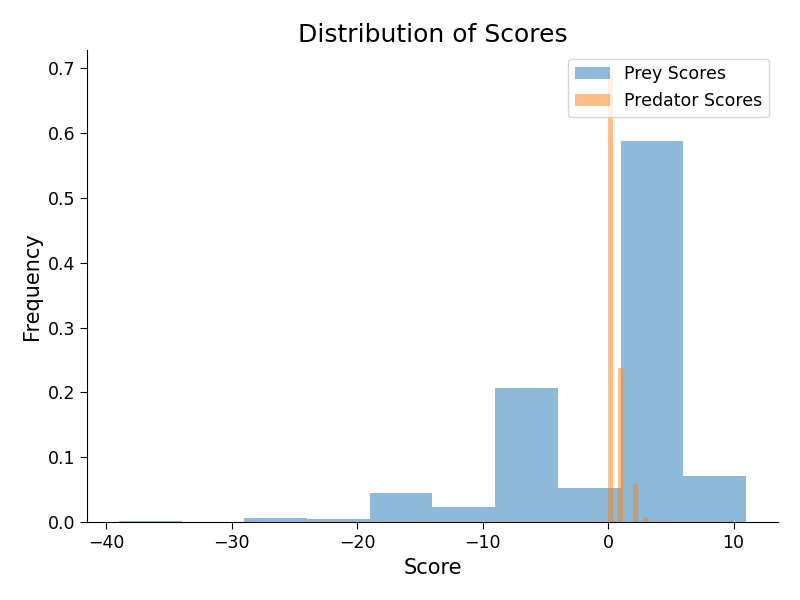

Average prey score: -0.7844444444444445
Average pred score: 0.3877777777777778


In [99]:
def evaluate_2_types(prey_player, prey_flat_W, pred_player, pred_flat_W,
                     game, opt_which='both', plt_hist=False):
  ''' Assumes player objects were instantiated with the passed in game '''

  prey_player.W = prey_flat_W.reshape(prey_player.W_shape)
  pred_player.W = pred_flat_W.reshape(pred_player.W_shape)

  final_board = game.play_game(players=[prey_player, pred_player], visualize=False)
  # Evaluate the score
  prey_scores = final_board['scores'][:, 0]
  pred_scores = final_board['scores'][:, 1]
  avg_prey_score = np.mean(prey_scores)
  avg_pred_score = np.mean(pred_scores)

  if plt_hist is True:
    fig, ax = plt.subplots()
    weights_prey = np.ones_like(prey_scores) / float(len(prey_scores))
    weights_pred = np.ones_like(pred_scores) / float(len(pred_scores))
    ax.hist(prey_scores, weights=weights_prey, alpha=0.5, label='Prey Scores')
    ax.hist(pred_scores, weights=weights_pred, alpha=0.5, label='Predator Scores')
    ax.legend(loc='upper right')
    ax.set_title("Distribution of Scores")
    ax.set_xlabel("Score")
    ax.set_ylabel("Probability")
    remove_ip_clutter(fig)
    plt.show()

  if opt_which == 'pred':
    return avg_pred_score
  elif opt_which == 'prey':
    return avg_prey_score
  elif opt_which == 'both':
    return(avg_prey_score, avg_pred_score)
  else:
    print("Unexpect opt_which value, expected 'pred', 'prey' or 'both'.")

gwg = GridworldGame(batch_size=900, num_prey=1, num_pred=1,
                    rng=np.random.default_rng(202))
prey_player_params = {'critter_index': 1, 'fov_radius': 1, 'speed': 1,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
prey_player = GeneralLinearPlayer(gwg, **prey_player_params)
pred_player_params = {'critter_index': 2, 'fov_radius': 1, 'speed': 1,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
pred_player = GeneralLinearPlayer(gwg, **pred_player_params)

avg_prey_score, avg_pred_score = evaluate_2_types(
    prey_player, np.ravel(np.zeros(prey_player.W_shape)),
    pred_player, np.ravel(np.zeros(pred_player.W_shape)),
    gwg, opt_which='both', plt_hist=True)
print(f'Average prey score: {avg_prey_score}')
print(f'Average pred score: {avg_pred_score}')

So when both organisms are just running a random drift policy, the average predator score is slightly positive, and the average prey score is slightly negative. This makes sense, as predator eating prey events are relatively rare, but lead to small score gains for the predators and big score losses for the prey, and these loses are not offset by the more frequent food eating events that a prey organism has.

Now that we have a working evaluation function we really are in a position to start optimizing. We will use a slightly accelerated version of the evolutionary algorithm we introduced in sequence 1.3.1, called Covariance Matrix Adapted Evolutionary Strategy (CMA-ES) which is just like our simple evolutionary algorithm except that the 'mutation' distribution (as determined by a covariance matrix) adapts over time to generate mutants that are more likely to increase fitness. (This can be though of as a kind of meta-evolution of mutatability.)

In [107]:
# @markdown You don't need to know how this code works right now, but you do need to run this cell, and you might want to skim this code out of curiousity.
def cma_es(n, eval_func, focal_pop=0, init_m=None, init_C=None, init_sigma=None,
           pop_size=None, select_frac=0.5, weight_scheme='skew', # other magic word is flat
           c_1=None, c_mu=None, c_c = None, c_sig = None, d_sig = None,
           max_gen=100, sigma_tol=0.0001, value_tol=0.0001,
           rng = np.random.default_rng(),
           verbose = True):
  # assumes eval_func returns scores for multiple populations
  # focal_pop indexes which of these scores is the one we are optimizing for
  # use heuristics to set constants if none provided
  # these are the same as in a simple ES algo
  if pop_size is None:
    pop_size = 4 + np.floor(3 * np.log(n))
    if verbose: print(f"pop_size set to: {pop_size}")
  select_size = int(np.floor(pop_size * select_frac))

  if weight_scheme == 'skew':
    mu_w = np.array([np.log(select_size + 0.5) - np.log(i)
                      for i in range(1, select_size + 1)])
    mu_w = mu_w / np.sum(mu_w)
    mu_eff = 1 / np.sum(mu_w**2)
    if verbose: print(f"mu_w set using skew scheme: {mu_w}")
    if verbose: print(f"mu_eff set to: {mu_eff}")
  elif weight_scheme == 'flat':
    mu_w = np.ones(select_size) / float(select_size)
    mu_eff = select_size / 2
    if verbose: print(f"mu_w set using flat scheme: {mu_w}")
    if verbose: print(f"mu_eff set to: {mu_eff}")

  # this is fancy stuff for updating the mutation distribution
  if c_1 is None:
    c_1 = 2 / n**2
    if verbose: print(f"c_1 set to: {c_1}")
  if c_mu is None:
    c_mu = min(1 - c_1, 2 * (mu_eff - 2 + 1/mu_eff) / (n + 2))
    if verbose: print(f"c_mu set to: {c_mu}")
  if c_c is None:
    c_c = (4 + mu_eff/n) / (n + 4 + 2 * mu_eff/n)
    if verbose: print(f"c_c set to: {c_c}")
  if c_sig is None:
    c_sig = (mu_eff + 2) / (n + mu_eff + 5)
    if verbose: print(f"c_sig set to: {c_sig}")
  if d_sig is None:
    d_sig = 1 + c_sig + 2 * max(0, np.sqrt((mu_eff - 1) / (n + 1)) - 1)
    if verbose: print(f"d_sig set to: {d_sig}")

  # Initialize variables of the process to these defaults if none given
  # (weighted) population mean parameters
  if init_m is None:
    m = np.zeros(n)
  else:
    m = init_m
  if init_C is None:
    # inially the Covariance of the proposal/offspring distribution is just
    # a standard i.i.d. Gaussian
    C = np.eye(n)
  else:
    C = init_C
  if init_sigma is None:
    sigma = 1.0
  else:
    sigma = init_sigma
  # p_c is used as a kind of momentum to inform how C is updated
  p_c = np.zeros(n)


  # Main loop
  mean_scores_history = []
  for gen in range(max_gen):
    # Steps 1-3 are standard Evolutionary Optimization
    # 1. Sampe params of this generation
    samples = rng.multivariate_normal(m, sigma**2 * C, size=int(pop_size))
    # 2. Evaluate each member of the new population
    fitness_values = np.vstack([eval_func(x) for x in samples])
    focal_fitness_values = fitness_values[:, focal_pop]
    sorted_indices = np.argsort(-focal_fitness_values) #argsort does low to high, so sort neg
    mean_scores = np.mean(fitness_values, axis=0)
    mean_scores_history.append(mean_scores)
    # If verbose flag is true, print generation info and mean score
    if verbose:
      print(f"Generation {gen + 1}/{max_gen}: Mean Score of Selected Population: {mean_scores[focal_pop]:.4f}")
    # 3. Update mean based on selection
    old_m = m.copy()
    selected_samples = samples[sorted_indices[:select_size]]
    m = (mu_w[:, np.newaxis].T @ selected_samples).squeeze()
    # Steps 4-7 are all about cleverly updating the sampling distribution
    # 4. Compute weighted sample deviations from the old mean
    y = np.sqrt(mu_w[:, np.newaxis]) * (selected_samples - old_m) / sigma
    # 5. Update the covariance matrix
    C = (1 - c_1 - c_mu) * C + c_1 * np.outer(p_c, p_c)
    C += c_mu * sum(np.outer(yi, yi) for yi in y)
    # 6. Update the evolution path
    p_c = (1 - c_c) * p_c + np.sqrt(c_c * (2 - c_c) * mu_eff) * (m - old_m) / sigma
    # 7. Adapt the step size sigma
    sigma *= np.exp(c_sig/d_sig * (np.linalg.norm(p_c) / np.sqrt(n) - 1))
    # 8. Check stopping criteria
    if sigma < sigma_tol:
        print("Stopping due to sigma below threshold.")
        break
    if np.abs(np.max(fitness_values) - np.min(fitness_values)) < value_tol:
        print("Stopping due to objective function values convergence.")
        break
  return m, C, mean_scores

In [109]:
# @title Optimzed Prey Policy when the Predator Drifts Randomly

game = GridworldGame(batch_size=64, n_rows=7, n_cols=7,
                     num_food=10, num_prey=1, num_pred=1,
                     lifetime=30, rng=np.random.default_rng(40))
# Initialize players
prey_player_params = {'critter_index': 1, 'fov_radius': 2, 'speed': 2,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
pred_player_params = {'critter_index': 2, 'fov_radius': 3, 'speed': 1,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
prey_player = GeneralLinearPlayer(game, **prey_player_params)
pred_player = GeneralLinearPlayer(game, **pred_player_params)
n_prey = np.prod(prey_player.W_shape)
n_pred = np.prod(pred_player.W_shape)

def eval_wrapper_for_prey(params):
  pred_flat_W = pred_player.W.flatten()  # Using current weights for predator
  opt_score = evaluate_2_types(
  prey_player, params, pred_player, pred_flat_W, game, opt_which='prey')
  return opt_score

opt_prey_weights, prey_cov, score_evo = cma_es(n_prey,
                                               eval_wrapper_for_prey,
                                               max_gen=100)


pop_size set to: 23.0
mu_w set using skew scheme: [0.26083671 0.18681028 0.1435076  0.11278385 0.08895266 0.06948117
 0.05301825 0.03875742 0.02617848 0.01492623 0.00474734]
mu_eff set to: 6.483721004119788
c_1 set to: 4.3765974580721965e-06
c_mu set to: 0.013681278545838858
c_c set to: 0.005896291466207945
c_sig set to: 0.012340250023271385
d_sig set to: 1.0123402500232714
Generation 1/100: Mean Score of Selected Population: -1.7609
Generation 2/100: Mean Score of Selected Population: -1.0836
Generation 3/100: Mean Score of Selected Population: -0.4395
Generation 4/100: Mean Score of Selected Population: 0.2235
Generation 5/100: Mean Score of Selected Population: 0.4239
Generation 6/100: Mean Score of Selected Population: 1.5591
Generation 7/100: Mean Score of Selected Population: 2.0143
Generation 8/100: Mean Score of Selected Population: 3.1318
Generation 9/100: Mean Score of Selected Population: 3.3906
Generation 10/100: Mean Score of Selected Population: 3.8193
Generation 11/100: 

In [111]:
opt_prey_weights.shape

(676,)

In [112]:
np.save('opt_prey_for_rand_pred.npy', opt_prey_weights)

In [95]:
prey_player_params = {'critter_index': 1, 'fov_radius': 2, 'speed': 2,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
pred_player_params = {'critter_index': 2, 'fov_radius': 3, 'speed': 1,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}

def eval_wrapper_for_pred(params):
    prey_flat_W = prey_player.W.flatten()  # Using current weights for prey
    opt_score = evaluate(
        prey_player, prey_flat_W, pred_player, params, game, opt_which='pred')
    return opt_score
def evaluate(prey_player, prey_flat_W, pred_player, pred_flat_W, game,
             opt_which):
  # assumes player objects were instantiated with the passed in game,
  # which is the case in the propose and test loop below
  # all we do is assign new w to the players

  prey_player.W = prey_flat_W.reshape(prey_player.W_shape)
  pred_player.W = pred_flat_W.reshape(pred_player.W_shape)
  #print(prey_player.W[0][0])
  #print(pred_player.W[0][0])

  final_board = game.play_game(players=[pred_player, prey_player], visualize=False)
  # Evaluate the score
  prey_scores = final_board['scores'][:, 0]
  pred_scores = final_board['scores'][:, 1]
  avg_prey_score = np.mean(prey_scores)
  avg_pred_score = np.mean(pred_scores)
  if opt_which == 'pred':
    opt_score = avg_pred_score
  elif opt_which == 'prey':
    opt_score = avg_prey_score
  return(opt_score, avg_prey_score, avg_pred_score)


def propose_and_test(batch_size=25, high_batch_size=900,
                     init_prey_W=None, init_pred_W=None,
                     opt_which = 'prey', #or 'pred', magic string
                     max_rejected=1000,
                     step_scale=10.0,
                     verbose=True):

  game = GridworldGame(batch_size=batch_size, n_rows=7, n_cols=7,
                       num_food=10, num_prey=1, num_pred=1,
                       lifetime=30, rng=np.random.default_rng(40))
  high_batch_game = GridworldGame(batch_size=high_batch_size,
                                  n_rows=7, n_cols=7,
                                  num_food=10, num_prey=1, num_pred=1,
                                  lifetime=30, rng=np.random.default_rng(40))
  # Initialize players
  prey_player = GeneralLinearPlayer(game, **prey_player_params)
  pred_player = GeneralLinearPlayer(game, **pred_player_params)
  hb_prey_p   = GeneralLinearPlayer(high_batch_game, **prey_player_params)
  hb_pred_p   = GeneralLinearPlayer(high_batch_game, **pred_player_params)
  if init_prey_W is None:
    # params are flat in the loop for sampling, reshaped in the evaluate func
    init_prey_W = np.zeros(np.prod(prey_player.W_shape))
  if init_pred_W is None:
    init_pred_W = np.zeros(np.prod(pred_player.W_shape))
  best_prey_W = init_prey_W
  best_pred_W = init_pred_W
  if opt_which == 'prey':
    best_params = best_prey_W
  elif opt_which == 'pred':
    best_params = best_pred_W
  else:
    print("Expected 'pred', or 'prey' for magic string opt_which")
  (best_score, best_avg_prey_score, best_avg_pred_score) = evaluate(
      hb_prey_p, best_prey_W,
      hb_pred_p, best_pred_W,
      high_batch_game, opt_which)
  print(f"Initial prey score: {best_avg_prey_score}")
  print(f"Initial pred score: {best_avg_pred_score}")
  print('Beginning Optimization of ' + opt_which + ' params.')
  rejected_count = 0
  total_tests = 0  # Number of iterations
  std_dev = step_scale  # Standard deviation for Gaussian proposal
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample from Gaussian centered at best_params
    delta_params = np.random.normal(0, std_dev, best_params.shape)
    proposal_W = best_params + delta_params

    avg_score, _, _ = evaluate(
        prey_player, proposal_W if opt_which == 'prey' else best_prey_W,
        pred_player, proposal_W if opt_which == 'pred' else best_pred_W,
        game, opt_which)
    # If a promising candidate is found in the low batch game,
    # validate it with a high batch game evaluation
    if avg_score > best_score:
      avg_score_high_batch, _, _ = evaluate(
          hb_prey_p, proposal_W if opt_which == 'prey' else best_prey_W,
          hb_pred_p, proposal_W if opt_which == 'pred' else best_pred_W,
          high_batch_game, opt_which)

      # Update best parameters if the candidate also performs well in the
      # high batch size evaluation
      if avg_score_high_batch > best_score:
        best_score = avg_score
        best_W = proposal_W
        if verbose:
          #print('best params so far:')
          #display(best_params)
          print(f"Best score so far: {best_score}")
          print(f"Found after a total of {time.time() - start_time:.2f} seconds and an additional {rejected_count} tests")
          intermediate_params.append(best_W)
          intermediate_values.append(best_score)
          iterations.append(total_tests)
        rejected_count = 0
      else:
        rejected_count += 1
    else:
      rejected_count += 1
  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_W)
    print("Best Average Score:", best_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_W, best_score, intermediate_params,
            intermediate_values, iterations)
  else:
    return best_params, best_avg_score

result = propose_and_test(opt_which='prey')
best_params = result[0]

2
1


ValueError: ignored

In [ ]:
opred_W, oprey_W = pred_prey_cma_es_loop()

In [ ]:
def two_pop_cma_es(n1, n2, eval_func, init_m1=None, initm2=None,
                   init_C1=None, initC2=None, init_sigma1=None, init_sigma2=None
                   pop_size=None, select_frac=0.5, weight_scheme='skew', # other magic word is flat
                   c_1=None, c_mu=None, c_c = None, c_sig = None, d_sig = None,
                   max_gen=100, sigma_tol=0.0001, value_tol=-0.0001,
                   rng = np.random.default_rng(), verbose = True):

  # use heuristics to set constants if none provided
  if pop_size is None:
    pop_size = 4 + np.floor(3 * np.log(n))
    if verbose: print(f"pop_size set to: {pop_size}")
  select_size = int(np.floor(pop_size * select_frac))

  if weight_scheme == 'skew':
    mu_w = np.array([np.log(select_size + 0.5) - np.log(i)
                      for i in range(1, select_size + 1)])
    mu_w = mu_w / np.sum(mu_w)
    mu_eff = 1 / np.sum(mu_w**2)
    if verbose: print(f"mu_w set using skew scheme: {mu_w}")
    if verbose: print(f"mu_eff set to: {mu_eff}")
  elif weight_scheme == 'flat':
    mu_w = np.ones(select_size) / float(select_size)
    mu_eff = select_size / 2
    if verbose: print(f"mu_w set using flat scheme: {mu_w}")
    if verbose: print(f"mu_eff set to: {mu_eff}")

  if c_1 is None:
    c_1 = 2 / n**2
    if verbose: print(f"c_1 set to: {c_1}")
  if c_mu is None:
    c_mu = min(1 - c_1, 2 * (mu_eff - 2 + 1/mu_eff) / (n + 2))
    if verbose: print(f"c_mu set to: {c_mu}")
  if c_c is None:
    c_c = (4 + mu_eff/n) / (n + 4 + 2 * mu_eff/n)
    if verbose: print(f"c_c set to: {c_c}")
  if c_sig is None:
    c_sig = (mu_eff + 2) / (n + mu_eff + 5)
    if verbose: print(f"c_sig set to: {c_sig}")
  if d_sig is None:
    d_sig = 1 + c_sig + 2 * max(0, np.sqrt((mu_eff - 1) / (n + 1)) - 1)
    if verbose: print(f"d_sig set to: {d_sig}")

  # Initialize variables of the process to these defaults if none given
  if init_m1 is None:
    m1 = np.zeros(n1)
  else:
    m1 = init_m1
  if init_m2 is None:
    m2 = np.zeros(n2)
  else:
    m2 = init_m2
  if init_C1 is None:
    C1 = np.eye(n1)
  else:
    C1 = init_C1
  if init_C2 is None:
    C2 = np.eye(n2)
  else:
    C2 = init_C2
  if init_sigma1 is None:
    sigma1 = 1.0
  else:
    sigma1 = init_sigma1
  if init_sigma2 is None:
    sigma2 = 1.0
  else:
    sigma2 = init_sigma2
  p_c1 = np.zeros(n1)
  p_c2 = np.zeros(n2)


  # Main loop
  mean_scores = []
  for gen in range(max_gen):
    # 1. Sampe params of this generation
    samples1 = rng.multivariate_normal(m1, sigma1**2 * C1, size=int(pop_size))
    samples2 = rng.multivariate_normal(m2, sigma2**2 * C2, size=int(pop_size))
    # 2. Evaluate each member of the new population
    fitness_values  = np.vstack([eval_func(x, y)
                                 for x, y in zip(samples1, samples2)])
    sorted_indices1 = np.argsort(-fitness_values[:,0]) #argsort does low to high, so sort neg
    sorted_indices2 = np.argsort(-fitness_values[:,1]) #argsort does low to high, so sort neg
    mean_scores = np.mean(fitness_values, axis=0)
    mean_scores.append(mean_score)
    # If verbose flag is true, print generation info and mean score
    if verbose:
      print(f"Generation {gen + 1}/{max_gen}: Mean Score of Population 1: {mean_scores[0]:.4f}")
      print(f"Generation {gen + 1}/{max_gen}: Mean Score of Population 2: {mean_scores[1]:.4f}")
    # 3. Update mean as a weighted sum of the selected samples
    old_m1 = m1.copy()
    old_m2 = m2.copy()
    selected_samples1 = samples1[sorted_indices1[:select_size]]
    selected_samples2 = samples2[sorted_indices2[:select_size]]
    m1 = (mu_w[:, np.newaxis].T @ selected_samples1).squeeze()
    m2 = (mu_w[:, np.newaxis].T @ selected_samples2).squeeze()
    # 4. Compute weighted sample deviations from the old mean
    y1 = np.sqrt(mu_w[:, np.newaxis]) * (selected_samples1 - old_m1) / sigma1
    y2 = np.sqrt(mu_w[:, np.newaxis]) * (selected_samples2 - old_m2) / sigma2
    # 5. Update the covariance matrix
    C1 = (1 - c_1 - c_mu) * C1 + c_1 * np.outer(p_c1, p_c1)
    C1 += c_mu * sum(np.outer(yi, yi) for yi in y1)
    C2 = (1 - c_1 - c_mu) * C2 + c_1 * np.outer(p_c2, p_c2)
    C2 += c_mu * sum(np.outer(yi, yi) for yi in y2)
    # 6. Update the evolution path
    p_c1 = (1 - c_c) * p_c1 + np.sqrt(c_c * (2 - c_c) * mu_eff) * (m1 - old_m1) / sigma1
    p_c2 = (1 - c_c) * p_c2 + np.sqrt(c_c * (2 - c_c) * mu_eff) * (m2 - old_m2) / sigma2
    # 7. Adapt the step size sigma
    sigma1 *= np.exp(c_sig/d_sig * (np.linalg.norm(p_c1) / np.sqrt(n) - 1))
    sigma2 *= np.exp(c_sig/d_sig * (np.linalg.norm(p_c2) / np.sqrt(n) - 1))
    # 8. Check stopping criteria
    if sigma1 < sigma_tol and sigma2 < sigma_tol:
        print("Stopping due to sigma below threshold.")
        break
    if np.abs(np.max(fitness_values) - np.min(fitness_values)) < value_tol:
        print("Stopping due to objective function values convergence.")
        break
  return m1, C1, m2, C2, mean_scores


def dual_pred_prey_cma_es(batch_size=400, max_gen=500):
  game = GridworldGame(batch_size=batch_size, n_rows=7, n_cols=7,
                       num_food=10, num_prey=1, num_pred=1,
                       lifetime=30, rng=np.random.default_rng(40))
  # Initialize players
  prey_player_params = {'critter_index': 1, 'fov_radius': 2, 'speed': 2,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
  pred_player_params = {'critter_index': 2, 'fov_radius': 3, 'speed': 1,
                      'has_food_percept': True, 'has_edge_percept': True,
                      'has_prey_percept': True, 'has_pred_percept': True}
  prey_player = GeneralLinearPlayer(game, **prey_player_params)
  pred_player = GeneralLinearPlayer(game, **pred_player_params)
  n_prey = np.prod(prey_player.W_shape)
  n_pred = np.prod(pred_player.W_shape)

  # Optimize for prey using CMA-ES
  (optimal_prey_weights, optimal_prey_cov,
   optimal_pred_weights, optimal_pred_cov,
   mean_scores) = two_pop_cma_es(n_prey, n_pred)
  return optimal_pred_weights, optimal_prey_weights

In [ ]:
rng = np.random.default_rng()
rng.multivariate_normal(np.zeros(200), 5.0**2 * np.eye(200), size=10)

In [ ]:
result[2][-1]

In [ ]:
def evaluate(flat_W, game):
  # Run the game with the proposed weights
  W = flat_W.reshape((4,12))
  boppp = BatchOptPerceptParamPlayer(game, weights=W, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)
  return(avg_score)


def propose_and_test(batch_size=25, high_batch_size=900,
                     initial_params=None,
                     max_rejected=500,
                     step_scale=10.0,
                     verbose=True):

  game = GridworldGame(batch_size=batch_size, n_rows=7, n_cols=7,
                       num_critters=1, num_food=10, lifetime=30,
                       rng=np.random.default_rng(48))
  high_batch_game = GridworldGame(batch_size=high_batch_size, n_rows=7, n_cols=7,
                                  num_critters=1, num_food=10, lifetime=30,
                                  rng=np.random.default_rng(48))
  # Initialize parameters
  if initial_params is None:
    initial_params = np.zeros(48)
  best_params = initial_params
  best_avg_score = evaluate(best_params, high_batch_game)
  print(f"Initial score: {best_avg_score}")
  rejected_count = 0
  total_tests = 0  # Number of iterations
  std_dev = step_scale  # Standard deviation for Gaussian proposal
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_avg_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample from Gaussian centered at best_params
    delta_params = np.random.normal(0, std_dev, best_params.shape)
    proposal_params = best_params + delta_params
    avg_score = evaluate(proposal_params, game)
    # If a promising candidate is found,
    # validate it with a high batch size evaluation
    if avg_score > best_avg_score:
      avg_score_high_batch = evaluate(proposal_params, high_batch_game)
      # Only update best parameters if the candidate also performs well in the
      # high batch size evaluation to avoid choosing parameters based on 'luck'
      # i.e. from a really exceptional batch of simulations
      if avg_score_high_batch > best_avg_score:
        best_avg_score = avg_score
        best_params = proposal_params
        if verbose:
          #print('best params so far:')
          #display(best_params)
          print(f"Best score so far: {best_avg_score}")
          print(f"Found after a total of {time.time() - start_time:.2f} seconds and an additional {rejected_count} tests")
          intermediate_params.append(best_params)
          intermediate_values.append(best_avg_score)
          iterations.append(total_tests)
        rejected_count = 0
      else:
        rejected_count += 1
    else:
      rejected_count += 1
  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_params)
    print("Best Average Score:", best_avg_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_params, best_avg_score, intermediate_params,
            intermediate_values, iterations)
  else:
    return best_params, best_avg_score

result = propose_and_test(initial_params=None)
best_params = result[0]

In [ ]:
# @title Optimized for Stationary Food, but Food Drifts
# @markdown Run this cell to see our optimized policy from last  in an environment that they were not optimized for.
gwg = GridworldGame(batch_size=1, n_rows=7, n_cols=7,
                    num_critters=1, num_food=10, lifetime=30,
                    drift_probs=np.array([0.0, 0.0, 1.0, 0.0, 0.0]),
                    wrapping=True, drift_after_move=False)
sym_weights = np.array([ 711.9256878,  -188.34681299,
                        700.65707005,   397.25119332,
                        -36.91700298,   -227.4452487,
                        231.42719449,   367.63939442])
def convert_symmetry_to_weights(symmetry_params):
  # Initialize the weight matrix with zeros
  weights = np.zeros((4,12))
  symmetry_indices = {
    'Up':    [0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
    'Down':  [7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
    'Left':  [3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
    'Right': [3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}
  # Use the symmetry indices to populate the 48-dimensional weight vector
  for i, direction in enumerate(['Up', 'Down', 'Left', 'Right']):
    for j, idx in enumerate(symmetry_indices[direction]):
      weights[i, j] = symmetry_params[idx]
  return weights

weights = convert_symmetry_to_weights(sym_weights)
#ppp = PerceptParamPlayer(gwg, weights=weights)
boppp = BatchOptPerceptParamPlayer(gwg, weights=weights)
drift_igwg = InteractiveGridworld(gwg, players=[boppp],
                                  figsize=(5,4), has_fov=True,
                                  fov_opaque=False)
display(drift_igwg.b_fig.canvas)
clear_output()
display(drift_igwg.final_display)

In [ ]:
# @title How Good Are You at Catching the Drifting Food with Limited Perception
# @markdown Run this cell to try out the dirfting food environment. Pro Tips: The food drifts after you choose your action, but before it is executed. Food that would drift into the critter, or into other food locations, remains stationary.
gwg = GridworldGame(batch_size=2, n_rows=7, n_cols=7,
                    num_critters=1, num_food=10, lifetime=30,
                    drift_probs=np.array([0.0, 0.0, 1.0, 0.0, 0.0]),
                    wrapping=True, drift_after_move=False)
sym_weights = np.array([ 711.9256878,  -188.34681299,
                        700.65707005,   397.25119332,
                        -36.91700298,   -227.4452487,
                        231.42719449,   367.63939442])
def convert_symmetry_to_weights(symmetry_params):
  # Initialize the weight matrix with zeros
  weights = np.zeros((4,12))
  symmetry_indices = {
    'Up':    [0,  1,  2,  1,  3,  4,  4,  3,  5,  6,  5,  7],
    'Down':  [7,  5,  6,  5,  3,  4,  4,  3,  1,  2,  1,  0],
    'Left':  [3,  1,  4,  5,  0,  2,  6,  7,  1,  4,  5,  3],
    'Right': [3,  5,  4,  1,  7,  6,  2,  0,  5,  4,  1,  3]}
  # Use the symmetry indices to populate the 48-dimensional weight vector
  for i, direction in enumerate(['Up', 'Down', 'Left', 'Right']):
    for j, idx in enumerate(symmetry_indices[direction]):
      weights[i, j] = symmetry_params[idx]
  return weights

weights = convert_symmetry_to_weights(sym_weights)
#ppp = PerceptParamPlayer(gwg, weights=weights)
boppp = BatchOptPerceptParamPlayer(gwg, weights=weights)
drift_h2hgw = Head2HeadGridworld(gwg, player0='human',
                                 p0_short_name='YOU',
                                 p0_long_name='The Human',
                                 player1=boppp,
                                 p1_short_name='Params',
                                 p1_long_name='Optimized for\nNo Drift',
                                 figsize=(4,4), has_fov=True,
                                 fov_opaque=True)
display(drift_h2hgw.b_fig0.canvas)
display(drift_h2hgw.b_fig1.canvas)
clear_output()
display(drift_h2hgw.final_display)

In many ways this new drifting food environment is 'unfair' for our policy from last time. One particularly 'unfair' aspect is the  of events in this new Gridworld: first the organism decides its move based on its perceptions, then the food drifts, and only after that does the organism move. This sequencing can lead the organism on a fruitless chase across the board, never catching its target. To be truly effective in this variant, the organism's actions must anticipate the potential movement of the food.

Another 'unfair' aspect of this drifting food environment is its asymmetry: food consistently drifts to the left. Yet, the organism as optimized in the previous , was constrained to have symmetric weights. We imposed this symmetry constraint in the last  to simplify our optimization problem, reducing the number of parameters to be optimized from 48 (12 inputs $\times$ 4 output directions) to just 8. However, an effective policy in this asymmetric environment might need to break out of this symmetry constraint.

Can our simple 'propose and test' algorithm from the previous sequence handle this higher dimension optimization problem (where the symmetry constraint is lifted)? Run the cell below to find out. (This might take a few minutes, so consider reading ahead while you wait.)

In [ ]:
def evaluate(flat_W, game):
  # Run the game with the proposed weights
  W = flat_W.reshape((4,12))
  boppp = BatchOptPerceptParamPlayer(game, weights=W, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)
  return(avg_score)


def propose_and_test(batch_size=25, high_batch_size=900,
                     initial_params=None,
                     max_rejected=500,
                     step_scale=10.0,
                     verbose=True):

  game = GridworldGame(batch_size=batch_size, n_rows=7, n_cols=7,
                       num_critters=1, num_food=10, lifetime=30,
                       rng=np.random.default_rng(48))
  high_batch_game = GridworldGame(batch_size=high_batch_size, n_rows=7, n_cols=7,
                                  num_critters=1, num_food=10, lifetime=30,
                                  rng=np.random.default_rng(48))
  # Initialize parameters
  if initial_params is None:
    initial_params = np.zeros(48)
  best_params = initial_params
  best_avg_score = evaluate(best_params, high_batch_game)
  print(f"Initial score: {best_avg_score}")
  rejected_count = 0
  total_tests = 0  # Number of iterations
  std_dev = step_scale  # Standard deviation for Gaussian proposal
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_avg_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample from Gaussian centered at best_params
    delta_params = np.random.normal(0, std_dev, best_params.shape)
    proposal_params = best_params + delta_params
    avg_score = evaluate(proposal_params, game)
    # If a promising candidate is found,
    # validate it with a high batch size evaluation
    if avg_score > best_avg_score:
      avg_score_high_batch = evaluate(proposal_params, high_batch_game)
      # Only update best parameters if the candidate also performs well in the
      # high batch size evaluation to avoid choosing parameters based on 'luck'
      # i.e. from a really exceptional batch of simulations
      if avg_score_high_batch > best_avg_score:
        best_avg_score = avg_score
        best_params = proposal_params
        if verbose:
          #print('best params so far:')
          #display(best_params)
          print(f"Best score so far: {best_avg_score}")
          print(f"Found after a total of {time.time() - start_time:.2f} seconds and an additional {rejected_count} tests")
          intermediate_params.append(best_params)
          intermediate_values.append(best_avg_score)
          iterations.append(total_tests)
        rejected_count = 0
      else:
        rejected_count += 1
    else:
      rejected_count += 1
  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_params)
    print("Best Average Score:", best_avg_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_params, best_avg_score, intermediate_params,
            intermediate_values, iterations)
  else:
    return best_params, best_avg_score

result = propose_and_test(initial_params=None)
best_params = result[0]

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.2.2.2 Optimizing for Drifting Food
Finding a good set of parameters in an 8-dimensional space was certainly easier than in a 48-dimensional space. However, given enough time and appropriate hyper-parameter settings, our simple 'propose and test' algorithm is up to the task. We just tested this optimization algorithm in the no-drift environment, but with the relaxed symmetry constraint. This tells us that it's a feasible approach for optimizing parameters even when the food drifts. So now, let's adapt our 'propose and test' process above to tune the parameters of a policy so that it performs well in an environment where food drifts.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to adapt the propose and test
# function above to work in an environment where food drifts. Then comment out
# the line below.
raise NotImplementedError("Exercise: adapt propose and test")
################################################################################


def drift_propose_and_test(batch_size=25, high_batch_size=900,
                           initial_params=None,
                           max_rejected=500,
                           step_scale=10.0,
                           verbose=True,
                           drift_probs = [0, 0, 1.0, 0, 0]):

  game = GridworldGame(batch_size=batch_size, n_rows=7, n_cols=7,
                       num_critters=1, num_food=10, lifetime=30,
                       rng=np.random.default_rng(48),
                       drift_probs=...,
                       wrapping=True, drift_after_move=False)
  high_batch_game = GridworldGame(batch_size=high_batch_size, n_rows=7, n_cols=7,
                                  num_critters=1, num_food=10, lifetime=30,
                                  rng=np.random.default_rng(48),
                                  drift_probs=...,
                                  wrapping=True, drift_after_move=False)
  # Initialize parameters
  if initial_params is None:
    initial_params = np.zeros(48)
  best_params = initial_params
  best_avg_score = evaluate(best_params, high_batch_game)
  print(f"Initial score: {best_avg_score}")
  rejected_count = 0
  total_tests = 0  # Number of iterations
  std_dev = step_scale  # Standard deviation for Gaussian proposal
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_avg_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample from Gaussian centered at best_params
    delta_params = np.random.normal(0, std_dev, best_params.shape)
    proposal_params = best_params + delta_params
    avg_score = evaluate(proposal_params, game)
    # If a promising candidate is found, validate it with a high batch size evaluation
    if avg_score > best_avg_score:
      avg_score_high_batch = evaluate(proposal_params, high_batch_game)
      # Only update best parameters if the candidate also performs well in the
      # high batch size evaluation to avoid choosing parameters based on 'luck'
      # i.e. from a really exceptional batch of simulations
      if avg_score_high_batch > best_avg_score:
        best_avg_score = avg_score
        best_params = proposal_params
        if verbose:
          #print('best params so far:')
          #display(best_params)
          print(f"Best score so far: {best_avg_score}")
          print(f"Found after a total of {time.time() - start_time:.2f} seconds and an additional {rejected_count} tests")
          intermediate_params.append(best_params)
          intermediate_values.append(best_avg_score)
          iterations.append(total_tests)
        rejected_count = 0
      else:
        rejected_count += 1
    else:
      rejected_count += 1
  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_params)
    print("Best Average Score:", best_avg_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_params, best_avg_score, intermediate_params,
            intermediate_values, iterations)
  else:
    return best_params, best_avg_score

drift_result = drift_propose_and_test(initial_params=None,
                                      drift_probs=[0, 0, 1.0, 0, 0])
best_drift_params = drift_result[0]

In [ ]:
# to_remove solution
def drift_propose_and_test(batch_size=25, high_batch_size=900,
                           initial_params=None,
                           max_rejected=500,
                           step_scale=10.0,
                           verbose=True,
                           drift_probs = [0, 0, 1.0, 0, 0]):

  game = GridworldGame(batch_size=batch_size, n_rows=7, n_cols=7,
                       num_critters=1, num_food=10, lifetime=30,
                       rng=np.random.default_rng(48),
                       drift_probs=drift_probs,
                       wrapping=True, drift_after_move=False)
  high_batch_game = GridworldGame(batch_size=high_batch_size, n_rows=7, n_cols=7,
                                  num_critters=1, num_food=10, lifetime=30,
                                  rng=np.random.default_rng(48),
                                  drift_probs=drift_probs,
                                  wrapping=True, drift_after_move=False)
  # Initialize parameters
  if initial_params is None:
    initial_params = np.zeros(48)
  best_params = initial_params
  best_avg_score = evaluate(best_params, high_batch_game)
  print(f"Initial score: {best_avg_score}")
  rejected_count = 0
  total_tests = 0  # Number of iterations
  std_dev = step_scale  # Standard deviation for Gaussian proposal
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_avg_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample from Gaussian centered at best_params
    delta_params = np.random.normal(0, std_dev, best_params.shape)
    proposal_params = best_params + delta_params
    avg_score = evaluate(proposal_params, game)
    # If a promising candidate is found, validate it with a high batch size evaluation
    if avg_score > best_avg_score:
      avg_score_high_batch = evaluate(proposal_params, high_batch_game)
      # Only update best parameters if the candidate also performs well in the
      # high batch size evaluation to avoid choosing parameters based on 'luck'
      # i.e. from a really exceptional batch of simulations
      if avg_score_high_batch > best_avg_score:
        best_avg_score = avg_score
        best_params = proposal_params
        if verbose:
          #print('best params so far:')
          #display(best_params)
          print(f"Best score so far: {best_avg_score}")
          print(f"Found after a total of {time.time() - start_time:.2f} seconds and an additional {rejected_count} tests")
          intermediate_params.append(best_params)
          intermediate_values.append(best_avg_score)
          iterations.append(total_tests)
        rejected_count = 0
      else:
        rejected_count += 1
    else:
      rejected_count += 1
  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_params)
    print("Best Average Score:", best_avg_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_params, best_avg_score, intermediate_params,
            intermediate_values, iterations)
  else:
    return best_params, best_avg_score

drift_result = drift_propose_and_test(initial_params=None,
                                      drift_probs=[0, 0, 1.0, 0, 0])
best_drift_params = drift_result[0]

Great! Now that we have a policy optimized for the drifting food environment, run the cell below to see its performance in the very environment it was optimized for.

In [ ]:
# @title Behaviour Optimized for Drifting Food in a Gridworld where Food Drifts
# @markdown Run this cell to watch policy tuned for this drifting environment. For comparison, the policy optimized for a 'No Drift' environment is also shown.
gwg = GridworldGame(batch_size=2, n_rows=7, n_cols=7,
                    num_critters=1, num_food=10, lifetime=30,
                    drift_probs=np.array([0.0, 0.0, 1.0, 0.0, 0.0]),
                    wrapping=True, drift_after_move=False)

try:
  flat_classic_weights = best_params
except NameError:
  flat_classic_weights = np.array([
    72.44502999, -10.1196398,   75.58460857,   6.30015161,  22.72267252,
   -21.87763734, -25.29124192, -37.70261395, -32.06002976, -37.55333989,
     3.05150248, -10.64373529,  -6.70861488, -25.30559016, -56.576501,
    16.30638079,  10.80652839,  -0.85537565, -61.01324566, -37.03868886,
    21.13524191,  18.40083665, -25.36843063,  43.14481738,  29.39306285,
   -24.54420009,  -2.0335233,   -0.31976222,  40.61494124,  57.30685941,
   -34.73713881, -30.63781385,   8.45863857, -32.02285974,  -9.81967995,
    19.31799882,  -5.87473403, -10.68178413, -54.75878878,  21.34389051,
     6.64222051, -71.77728684,  11.06174306,  12.94640783, -13.26093112,
   -23.2402532,    9.96075751,  25.32552931])

try:
  flat_drift_weights = best_drift_params
except NameError:
  flat_drift_weights = np.array([
         37.89629402,  -48.2903797 ,  104.57227396,   82.96216298,
        -33.72075405,  -11.60406537,  -13.81356909,  -51.3297726 ,
        -88.41182722,  -40.9836382 ,  -11.69845196,   26.95174635,
         14.99113154,  -42.84500512,  -31.22642526,    0.8173807 ,
         14.84325766,    5.03038252, -103.05269519,  -28.56967293,
         51.6487887 ,   73.90697663,   18.44399746,   76.73473352,
         40.74093128,  -42.35290311,   45.31994088,  -31.84604343,
          8.83368266,   81.59865548,   -5.40502478,  -72.75935279,
         46.0222178 ,  -64.32899446,   -1.39618574,   45.16903944,
          2.57398304,  -65.45567314,  -24.56553091,    0.86333044,
         45.63555023,  -56.93741837,   10.23266167,  -13.28302046,
         29.150387  ,  -39.25495485,  -31.43520672,   31.85720807])

#ppp = PerceptParamPlayer(gwg, weights=weights)
drift_boppp = BatchOptPerceptParamPlayer(
    gwg, weights=flat_drift_weights.reshape(4,12))
classic_boppp = BatchOptPerceptParamPlayer(
    gwg, weights=flat_classic_weights.reshape(4,12))
h2hgw = Head2HeadGridworld(
    gwg, player0=drift_boppp, p0_short_name='Drift',
    player1=classic_boppp, p1_short_name='Classic',
    p0_long_name='Optimized for Drift',
    p1_long_name='Optimized for No Drift',
    figsize=(4,4), has_fov=True)
display(h2hgw.b_fig0.canvas)
display(h2hgw.b_fig1.canvas)
clear_output()
display(h2hgw.final_display)

While it may seem obvious, it's worth emphasizing: The parameters optimized for the environment with drift will be different from those optimized for the environment without drift. Furthermore, a policy using parameters optimized for an environment that is different from the one it is currently in is likely to perform poorly. In the code cell below, pass the appropriate arguments to the evaluate function to produce a 2 x 2 contingency table that illustrates this point.


In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to evaluate two different
# sets of parameters in two different Gridworld environments.
raise NotImplementedError("Exercise: make a 2x2 contingency table")
################################################################################


def evaluate(flat_W, game):
  # Run the game with the proposed weights
  W = flat_W.reshape((4,12))
  boppp = BatchOptPerceptParamPlayer(game, weights=W, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)
  return(avg_score)


no_drift_game = GridworldGame(batch_size=900, n_rows=7, n_cols=7,
                              num_critters=1, num_food=10, lifetime=30,
                              rng=np.random.default_rng(48),
                              drift_probs=None)
drift_game = GridworldGame(batch_size=900, n_rows=7, n_cols=7,
                           num_critters=1, num_food=10, lifetime=30,
                           rng=np.random.default_rng(48),
                           drift_probs=[0, 0, 1.0, 0, 0.0],
                           wrapping=True, drift_after_move=False)
try:
  # try use the params we found earlier
  good_no_drift_params = best_params
except NameError:
  # Use some 'canned' parameters if skipping ahead
  good_no_drift_params = np.array([
    72.44502999, -10.1196398,   75.58460857,   6.30015161,  22.72267252,
   -21.87763734, -25.29124192, -37.70261395, -32.06002976, -37.55333989,
     3.05150248, -10.64373529,  -6.70861488, -25.30559016, -56.576501,
    16.30638079,  10.80652839,  -0.85537565, -61.01324566, -37.03868886,
    21.13524191,  18.40083665, -25.36843063,  43.14481738,  29.39306285,
   -24.54420009,  -2.0335233,   -0.31976222,  40.61494124,  57.30685941,
   -34.73713881, -30.63781385,   8.45863857, -32.02285974,  -9.81967995,
    19.31799882,  -5.87473403, -10.68178413, -54.75878878,  21.34389051,
     6.64222051, -71.77728684,  11.06174306,  12.94640783, -13.26093112,
   -23.2402532,    9.96075751,  25.32552931])
try:
  # try use the params we found earlier
  good_drift_params = best_drift_params
except NameError:
  # Use some 'canned' parameters if skipping ahead
  good_drift_params = np.array([
         37.89629402,  -48.2903797 ,  104.57227396,   82.96216298,
        -33.72075405,  -11.60406537,  -13.81356909,  -51.3297726 ,
        -88.41182722,  -40.9836382 ,  -11.69845196,   26.95174635,
         14.99113154,  -42.84500512,  -31.22642526,    0.8173807 ,
         14.84325766,    5.03038252, -103.05269519,  -28.56967293,
         51.6487887 ,   73.90697663,   18.44399746,   76.73473352,
         40.74093128,  -42.35290311,   45.31994088,  -31.84604343,
          8.83368266,   81.59865548,   -5.40502478,  -72.75935279,
         46.0222178 ,  -64.32899446,   -1.39618574,   45.16903944,
          2.57398304,  -65.45567314,  -24.56553091,    0.86333044,
         45.63555023,  -56.93741837,   10.23266167,  -13.28302046,
         29.150387  ,  -39.25495485,  -31.43520672,   31.85720807])
data = {
  "no_drift_game": [evaluate(..., ...),
                    evaluate(..., ...)],
  "drift_game": [evaluate(..., ...),
                 evaluate(..., ...)]
}
df = pd.DataFrame.from_dict(data, orient='index',
                            columns=["good_no_drift_params", "good_drift_params"])
display(df)

In [ ]:
# to_remove solution


def evaluate(flat_W, game):
  # Run the game with the proposed weights
  W = flat_W.reshape((4,12))
  boppp = BatchOptPerceptParamPlayer(game, weights=W, deterministic=False)
  final_board = game.play_game(players=[boppp], visualize=False)
  # Evaluate the score
  scores = final_board['scores'].flatten()
  avg_score = np.mean(scores)
  return(avg_score)


no_drift_game = GridworldGame(batch_size=900, n_rows=7, n_cols=7,
                              num_critters=1, num_food=10, lifetime=30,
                              rng=np.random.default_rng(48),
                              drift_probs=None)
drift_game = GridworldGame(batch_size=900, n_rows=7, n_cols=7,
                           num_critters=1, num_food=10, lifetime=30,
                           rng=np.random.default_rng(48),
                           drift_probs=[0, 0, 1.0, 0, 0.0],
                           wrapping=True, drift_after_move=False)
try:
  # try use the params we found earlier
  good_no_drift_params = best_params
except NameError:
  # Use some 'canned' parameters if skipping ahead
  good_no_drift_params = np.array([
    72.44502999, -10.1196398,   75.58460857,   6.30015161,  22.72267252,
   -21.87763734, -25.29124192, -37.70261395, -32.06002976, -37.55333989,
     3.05150248, -10.64373529,  -6.70861488, -25.30559016, -56.576501,
    16.30638079,  10.80652839,  -0.85537565, -61.01324566, -37.03868886,
    21.13524191,  18.40083665, -25.36843063,  43.14481738,  29.39306285,
   -24.54420009,  -2.0335233,   -0.31976222,  40.61494124,  57.30685941,
   -34.73713881, -30.63781385,   8.45863857, -32.02285974,  -9.81967995,
    19.31799882,  -5.87473403, -10.68178413, -54.75878878,  21.34389051,
     6.64222051, -71.77728684,  11.06174306,  12.94640783, -13.26093112,
   -23.2402532,    9.96075751,  25.32552931])
try:
  # try use the params we found earlier
  good_drift_params = best_drift_params
except NameError:
  # Use some 'canned' parameters if skipping ahead
  good_drift_params = np.array([
         37.89629402,  -48.2903797 ,  104.57227396,   82.96216298,
        -33.72075405,  -11.60406537,  -13.81356909,  -51.3297726 ,
        -88.41182722,  -40.9836382 ,  -11.69845196,   26.95174635,
         14.99113154,  -42.84500512,  -31.22642526,    0.8173807 ,
         14.84325766,    5.03038252, -103.05269519,  -28.56967293,
         51.6487887 ,   73.90697663,   18.44399746,   76.73473352,
         40.74093128,  -42.35290311,   45.31994088,  -31.84604343,
          8.83368266,   81.59865548,   -5.40502478,  -72.75935279,
         46.0222178 ,  -64.32899446,   -1.39618574,   45.16903944,
          2.57398304,  -65.45567314,  -24.56553091,    0.86333044,
         45.63555023,  -56.93741837,   10.23266167,  -13.28302046,
         29.150387  ,  -39.25495485,  -31.43520672,   31.85720807])
data = {
  "no_drift_game": [evaluate(good_no_drift_params, no_drift_game),
                    evaluate(good_drift_params, no_drift_game)],
  "drift_game": [evaluate(good_no_drift_params, drift_game),
                 evaluate(good_drift_params, drift_game)]
}
df = pd.DataFrame.from_dict(data, orient='index',
                            columns=["good_no_drift_params", "good_drift_params"])
display(df)

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.2.2.3 Optimization in a Constantly Changing Environment

he observation that a policy well-suited to one environment may not fare as well in another different environment might seem elementary. Similarly, the observation that many environments are perpetually in flux—where change is the only constant—may seem cliché. However, when these two basic truths are considered together, they begin to hint at the immense challenge of producing adaptive behaviors and phenotypes. This is the overarching optimization problem that both evolutionary and learning processes strive to address.

To highlight this challenge, consider the following simulation/animation. It begins with an environment where food consistently drifts to the left. This then transitions abruptly to an environment where food drifts upwards, followed by a shift where food moves to the right, and finally, where it drifts downward. Throughout these changes, our 'propose and test' optimization algorithm continues to adjust the parameters. The animation below showcases two key aspects: how the policy parameters adjust to better suit the new environment and how the average performance score initially drops with each environmental shift, only to gradually recover as the optimization algorithm fine-tunes the parameters to better align with the current environment.

In [ ]:
# @markdown Run this cell to watch an animation

main_url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C2_OptimizationAndEnvironment/static/P1C2S2_drift_env_ani.html'
backup_url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/P1C2_S2/sequences/P1C2_OptimizationAndEnvironment/static/P1C2S2_drift_env_ani.html'

def fetch_content_from_url(url):
  try:
    response = requests.get(url)
    if response.status_code != 200:
      print(f"Unexpected status code {response.status_code} for {url}")
      return None
    #print(f"Retrieved data from {url}")
    return response.content.decode()
  except RequestException as e:  # This will catch any RequestException including HTTPError
    print(f"Failed to download {url}. Error: {e}")
    return None

jshtml_str = fetch_content_from_url(main_url)

if jshtml_str is None:
  #try the backup url if first didn't work
  jshtml_str = fetch_content_from_url(backup_url)

if jshtml_str is None:
  # if neither url works regenerate from scratch
  print("Failed to retrieve animation.")
  print("Regenerating animation from scratch.")
  print("This will take a few minutes.")
  jshtml_str, _ = make_drift_animation()

def make_drift_animation():
  # For reference
  # drift_probs_order = ['up', 'down', 'left', 'right', 'still']
  env_results = []
  for env_ in [[0, 0, 1, 0, 0], [1, 0, 0, 0, 0],
               [0, 0, 0, 1, 0], [0, 1, 0, 0, 0]]:
    result = drift_propose_and_test(
      batch_size=25, high_batch_size=900, initial_params=None, max_rejected=400,
      step_scale=10.0, verbose=True, drift_probs = env_)
    env_results.append(result)

  values = [e[3] for e in env_results]
  time_steps = [e[4] for e in env_results]
  params = [list(np.array(e[2])[:,3]) for e in env_results]
  # assumes each env's times list should be exactly 1 longer than params or
  # values so that diff works as expected
  # whatever the stopping time, just show 50 after 'convergence'
  time_steps_edit = []
  for e_time_steps in time_steps:
    e_time_steps[-1] = e_time_steps[-2]+50
    time_steps_edit.append(e_time_steps)

  env_changes_abs_t = []
  comb_values = []
  comb_params = []
  cum_offset = 0
  for e in range(len(time_steps_edit)): # go through each env
    for ii, dif in enumerate(np.diff(time_steps_edit[e])):
      comb_values += [values[e][ii]] * dif
      comb_params += [params[e][ii]] * dif
    env_changes_abs_t.append(time_steps_edit[e][-1] + cum_offset)
    cum_offset += time_steps_edit[e][-1]
  #print(comb_values)
  max_time_step = len(comb_values)

  fig, (ax_value, ax_param) = plt.subplots(2, 1, sharex=True,
                                           figsize=(8, 6))
  value_line, = ax_value.plot([], [], '-')
  param_line, = ax_param.plot([], [], '-')
  ax_value.set_xlim(0, max_time_step)
  ax_value.set_ylim(min(comb_values) - 1, max(comb_values) + 1)
  ax_value.set_ylabel("Average Score")

  ax_param.set_xlim(0, max_time_step)
  ax_param.set_ylim(min(comb_params) - 1, max(comb_params) + 1)
  ax_param.set_xlabel("Parameter Combinations Tested")
  ax_param.set_ylabel("Weight Between\n'Right-Up Percept'\nand 'Move Up'")

  rendered_changes = set()
  # Initialization function for the animation
  def ani_init():
    value_line.set_data([], [])
    param_line.set_data([], [])
    return value_line, param_line

  # Update function for the animation
  def ani_update(t):
    # Draw new vertical lines if needed
    for change_t in env_changes_abs_t:
      if t > change_t and change_t not in rendered_changes:
        ax_value.axvline(change_t, color='red', linestyle='--')
        ax_param.axvline(change_t, color='red', linestyle='--')
        rendered_changes.add(change_t)

    value_line.set_data(range(t), comb_values[:t])
    param_line.set_data(range(t), comb_params[:t])
    return value_line, param_line

  ani = FuncAnimation(fig, ani_update,
                      frames=np.arange(start=0, stop=max_time_step, step=10),
                      init_func=ani_init, blit=True)
  jshtml_str = ani.to_jshtml()
  # if it wasn't available to download store it locally.
  with open("animation.html", "w") as f:
    f.write(jshtml_str)
  return jshtml, ani

display(HTML(jshtml_str))

This is the end of our (short) sequence looking into the centrality of the environment in optimization problems. We used our simple 'propose and test' optimization method, and saw that this method was able to find good parameters across a variety of environments, but that the parameters that were good in one environment were not well suited to other environments. So the ***same*** optimization process applied to different problems (environments) produced different behaviours that were better suited to that environment. This underscores a universal truth in optimization and adaptation: solutions are intricately tied to the context in which they were developed.

We also started to think a bit about adating to changing conditions. In upcoming sequences we will start to think even more about the importance of time-scales in adaptive behavior. Organisms need to figure out how to eat, and how to not be eaten ***quickly***, or they will die. Populations need to adapt to environmental changes ***quickly***, or they will go extinct.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "In the context of a drifting food environment, why does the same optimization process yields different policies in different environments?",
    "type": "multiple_choice",
    "answers": [
      {"answer": "Because the drifting food changes the environment unpredictably, causing random policies.",
       "correct": False,
       "feedback": "False. While the drifting food changes the environment, an optimization process will make systemmatic policy adjustments specific environment."
      },
      {"answer": "Because the optimization process is flawed and cannot handle drifting food.",
       "correct": False,
       "feedback": "False. The optimization process is not inherently flawed."
      },
      {"answer": "Because solutions are deeply intertwined with the context in which they are developed, environmental context is central in optimization.",
       "correct": True,
       "feedback": "Correct! The environment plays a crucial role in determining optimal solutions. The same optimization process can produce different solutions based on different environments."
      },
      {"answer": "Because the optimization process is inherently stochastic.",
       "correct": False,
       "feedback": "False. The 'propose and test' optimization process is inherently stochastic, but uses this to discover parameter values well suited to a specific environment."
      }
    ]
  },
  {
    "question": "What happens to the average performance score in the simulation when the environment abruptly changes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It remains constant throughout the transitions.",
        "correct": False,
        "feedback": "False. The performance score doesn't remain constant during environmental transitions."
      },
      {
        "answer": "It immediately improves upon an environmental shift.",
        "correct": False,
        "feedback": "False. An abrupt change in environment usually does not improve the score."
      },
      {
        "answer": "It initially drops with each environmental shift but gradually recovers as the optimization algorithm adjusts the parameters.",
        "correct": True,
        "feedback": "Correct! The score initially dips due to the changed dynamics but improves as the algorithm fine-tunes the parameters to the new environment."
      },
      {
        "answer": "It remains consistently low irrespective of environmental changes.",
        "correct": False,
        "feedback": "False. The score fluctuates based on how well the parameters are tuned to the environment."
      }
    ]
  }
]


display_quiz(comprehension_quiz)